In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
idx=pd.IndexSlice

import numpy as np

from datetime import datetime

import itertools

import statsmodels.api as sm
import statsmodels.formula.api as smf

In [3]:
%matplotlib inline

In [4]:
pd.__version__, np.__version__, sm.__version__

('2.2.3', '1.26.4', '0.14.2')

### Define models

In [8]:
def LMM(IDf, IsMob, IiTimePeriod, IbCorrData, IsCnt, IiModel,
           IbHoly, IbWeekend, IDDfHoly, IiFilterOcc):
   
    # check all values are real
    if not IDf.map(np.isreal).all(0)[IsMob]:
        IDf=IDf[pd.to_numeric(IDf[IsMob], errors='coerce').notnull()]
        IDf=IDf.dropna(subset=[IsMob])
    # levels to numeric values
    IDf=IDf[pd.to_numeric(IDf['Level'], errors='coerce').notnull()]

    # Df for keeping the first day of each occurrence for each level and region
    DfDate=IDf.loc[IDf.groupby(['Region','Level','NOccurrence'])['Date'].idxmin()][['Region','Level','NOccurrence','Date']].copy()
    # drop levels-occurrences lasting less than the chosen duration (14 days in main analysis)
    Dftemp=IDf[['Region','Date','Level','NOccurrence']].copy()
    Dftemp= Dftemp.groupby(['Region','Level','NOccurrence']).count()
    IndexLessPeriod=Dftemp[Dftemp['Date']<IiTimePeriod].index
    if len(IndexLessPeriod)!=0:
        IDf=IDf.set_index(['Region','Level','NOccurrence']).drop(index=IndexLessPeriod).reset_index()
    IDf.dropna(subset=[IsMob], inplace=True)

    # convert data column to float
    IDf.loc[:,IsMob]= IDf.loc[:,IsMob].values.astype(float)

    # drop holidays
    if IbHoly:
        if IsCnt in ['ZAF','SCO','ITA', 'CHL','Ont','CA']:
            IDf=IDf[~IDf['Date'].isin(IDDfHoly[IsCnt]['Date'])]  

    # for each Region, tier and occurrence keep only the first [# number of days: 14 in the main analysis]  
    IDf = IDf[['Region','Level','NOccurrence','Date', sMob,'TotDays','T_Level','DayWeek', 'Incidence']].sort_values(
    ['Region','Level','NOccurrence','Date']).groupby(['Region','Level','NOccurrence']).apply(
        lambda x: x.iloc[:IiTimePeriod].reset_index(drop=True),include_groups=False).reset_index().drop(columns=['level_3'])
        
        
    # add column for calculating the number of days in the year until the occurrence
    IDf['DaySeasonality']=[(Date-datetime(Date.year, 1,1)).days for Date in IDf.Date]  
    if IsCnt=='CHL' or IsCnt=='ZAF':
        lSinDays=[np.sin(2*np.pi/365*(iDate+(365/4-22))+np.pi) for iDate in IDf['DaySeasonality']]
    else:
        lSinDays=[np.sin(2*np.pi/365*(iDate+(365/4-22)))for iDate in IDf['DaySeasonality']]
    # use the new column for calculating the seasonality term
    IDf['Seasonality']= lSinDays

    # drop weekend days
    if IbWeekend:
        IDf=IDf[(IDf['DayWeek']!=5) & (IDf['DayWeek']!=6)]

    # filter on min number of iterations 
    aDropLev= (IDf.groupby('Level').max()['NOccurrence']<IiFilterOcc).loc[lambda x: x==True].index.values
    if len(aDropLev) == len(IDf.Level.drop_duplicates()):
        print ('Warning: dropping all tiers')
    if len(aDropLev) != len(IDf.Level.drop_duplicates()):
        print ('Tiers', aDropLev, ' dropped in ',IsCnt)
        if len(aDropLev) !=0:
            IDf= IDf.set_index('Level').drop(index=aDropLev).reset_index()
        if IbCorrData:
            for l in DaLevels[cnt]:
                # drop tiers where not enough data is avaliable
                if not(IDf[IDf['Level']==l].shape[0]>IDf[IDf['Level']==l].drop_duplicates('Region').shape[0]+1):
                    IDf.drop(IDf.loc[IDf['Level']==l].index, inplace=True)
        # drop entries with missing incidence data
        IDf=IDf.dropna(subset=['Incidence'])

        ## Define statisticl models ##
         # only Cumulative exposure
        if IiModel== 1:
            eq_Model = smf.mixedlm("{} ~C(Level)+ TotDays+ Seasonality  +C(DayWeek) ".format(IsMob), IDf,
                                   groups=IDf['Region'])
            
        # only within-tier duration
        if IiModel== 2:
            eq_Model = smf.mixedlm("{} ~C(Level)+ C(Level):T_Level + Seasonality + C(DayWeek)".format(IsMob), IDf,
                                   groups=IDf['Region'])
            
        # only repeated implementation
        if IiModel==3:
            eq_Model = smf.mixedlm("{} ~  C(Level) + C(Level):NOccurrence + Seasonality +C(DayWeek)".format(IsMob), IDf, 
                                       groups=IDf['Region'])
              
        # Cumulative exposure + within-tier duration 
        if IiModel==4:  
            eq_Model = smf.mixedlm("{} ~C(Level) + TotDays + C(Level):T_Level + Seasonality  +C(DayWeek)".format(IsMob), IDf,
                                  groups=IDf['Region'])
            
        #  Cumulative exposure + repeated implementation
        if IiModel==5:
            eq_Model = smf.mixedlm("{} ~C(Level)+ TotDays + C(Level):NOccurrence+ Seasonality +C(DayWeek)".format(IsMob), IDf, 
                                       groups=IDf['Region'])
            
        #  within-tier duration  + repeated implementation
        if IiModel==6:
            eq_Model = smf.mixedlm("{} ~C(Level) +  C(Level):T_Level+ C(Level):NOccurrence + Seasonality+ C(DayWeek)".format(IsMob), IDf, 
                                       groups=IDf['Region'])
             
        # all three temporal dimensions 
        if IiModel==7:
            eq_Model = smf.mixedlm("{} ~ C(Level) + C(Level):NOccurrence + C(Level):T_Level + TotDays + Seasonality + C(DayWeek)".format(IsMob), IDf, groups=IDf['Region'])
            
        # all three temporal dimensions + risk adaptation
        if IiModel == 8:
            eq_Model = smf.mixedlm("{} ~ C(Level) + C(Level):NOccurrence + C(Level):T_Level +\
            TotDays + Seasonality + Incidence +C(DayWeek)".format(IsMob), IDf, groups=IDf['Region'])    
            
        # all three temporal dimensions + risk adaptation + risk habituation
        if IiModel == 9:
            eq_Model = smf.mixedlm("{} ~ C(Level) + C(Level):NOccurrence + C(Level):T_Level +\
            TotDays + Seasonality + Incidence + Incidence:TotDays +C(DayWeek)".format(IsMob), IDf, groups=IDf['Region'])    

        # senstitivity to duration window
        if IiModel==10:
            eq_Model = smf.mixedlm("{} ~ C(Level) + C(Level):NOccurrence + C(Level):T_Level +\
            TotDays + Seasonality + Incidence + Incidence:TotDays +C(DayWeek)".format(IsMob), IDf, groups=IDf['Region']) 
        # sensitivity to number of iterations
        if IiModel==11:
            eq_Model = smf.mixedlm("{} ~ C(Level) + C(Level):NOccurrence + C(Level):T_Level +\
            TotDays + Seasonality + Incidence + Incidence:TotDays +C(DayWeek)".format(IsMob), IDf, groups=IDf['Region']) 
        # run LMM analysis
        LMM = eq_Model.fit(reml=False)

    else:
        LMM=DfDate

    return (LMM,IDf)



### Load Data

In [6]:
# store main data
DDfData=dict()
# store data holidays
DDfHoly=dict()

DiLenLevels= dict()
DaLevels= dict()
DlArea= dict()

# dict for associating the color to the tier number 
DColLev={1:'skyblue',2:'gold',3:'darkorange',4:'red',5:'purple',6:'navy'}
lMob=['Workplaces','Residential']
lCnt=['ITA','SCO','Ont','CA','ZAF', 'CHL']
# long names regions
DNames={'ITA':'Italy','SCO':'Scotland','Ont':'Ontario','CA':'California','ZAF':'South Africa', 
        'CHL':'Chile'}

sNameFile='Google'

DsMob=dict(zip(lCnt,[lMob]*len(lCnt)))

print ('You are using the {} mobility data'.format(sNameFile))
for cnt in lCnt[:]:
    print (cnt)
    if cnt=='CHL':
        sNameFile=''
    # load dataframe with holiday dates
    DDfHoly[cnt]=pd.read_csv('../../Data/Pandemic_Fatigue/Restrictions/'+cnt+'/'+cnt+'_Holidays.csv',parse_dates=['Date'])

    # load main data fime 
    DDfData[cnt]= pd.read_csv('../../Data/Pandemic_Fatigue/Mob'+sNameFile+'_Res_'+cnt+'.csv',parse_dates=['Date'])
    DDfData[cnt]= DDfData[cnt].sort_values(['Region','Date'])
    DDfData[cnt]['Level']= DDfData[cnt]['Level'].astype(int) 
                                    
    # add column with total days spent under NPIs
    days= pd.date_range(start=DDfData[cnt].drop_duplicates('Date').sort_values('Date').iloc[0].Date, end=
            DDfData[cnt].drop_duplicates('Date').sort_values('Date').iloc[-1].Date)
    DDaysCount=dict(zip(days,np.arange(1,len(days)+1)))
    DDfData[cnt]['TotDays']=[DDaysCount[day] for day in  DDfData[cnt].Date]
    
    # add column for the day of the week (0 for Monday and 6 for Sunday)
    DDfData[cnt]['DayWeek']=[day.weekday() for day in DDfData[cnt].Date]

    # add column within-tier days
    for reg in DDfData[cnt].drop_duplicates('Region')['Region']:
        # get the initial and final date of each occurrence
        aIndStart= np.insert(np.where(np.diff(DDfData[cnt].set_index(['Region']).loc[reg]['Level'].values)!=0)[0]+1,0 ,0)
        aIndEnd= np.insert(DDfData[cnt].set_index(['Region']).loc[reg].shape[0]-1, -1,
                           np.where(np.diff(DDfData[cnt].set_index(['Region']).loc[reg]['Level'].values)!=0)[0])

        aStartDate=DDfData[cnt].set_index(['Region']).loc[reg].iloc[aIndStart]['Date'].values
        aEndDate=DDfData[cnt].set_index(['Region']).loc[reg].iloc[aIndEnd]['Date'].values

        # construct dict counting the days in each occurrence (for a region and tier)
        DDaysTLev=dict(zip([i for d in range(aStartDate.shape[0]) for i in pd.date_range(start=aStartDate[d], end=aEndDate[d])],
                 [day for d in range(aStartDate.shape[0]) for day in np.arange(1,
                                        pd.date_range(start=aStartDate[d], end=aEndDate[d]).shape[0]+1)]))
        # cosnstruct column 
        lTLevel=[DDaysTLev[day] for day in DDfData[cnt].loc[DDfData[cnt]['Region']==reg,'Date']]
        DDfData[cnt].loc[DDfData[cnt]['Region']==reg,'T_Level']= lTLevel
    DDfData[cnt]= DDfData[cnt].astype({'T_Level':int})

    
    if cnt=='Ont':
        # drop early stage data for Toronto because it entered later the tiered restrictions system
        DDfData[cnt]=DDfData[cnt].drop(DDfData[cnt][DDfData[cnt]['Color']=='white'].index)                                
            
    if cnt=='CHL':
        DDfData[cnt]= DDfData[cnt].rename(columns={'In':'Residential', 'Out':'Workplaces'})

    DiLenLevels[cnt]= len(DDfData[cnt].drop_duplicates('Level'))
    DaLevels[cnt]= DDfData[cnt].drop_duplicates('Level').sort_values('Level')['Level'].values
    DlArea[cnt]= DDfData[cnt].drop_duplicates('Region')['Region'].values.tolist()

    # add column with occurrences 
    DDfData[cnt]['NOccurrence']=1
    # initiate dict for occurrences in each area
    DOcc= dict()
    for sArea in DlArea[cnt]:
        DOcc[sArea]=dict(zip(DaLevels[cnt],np.ones(DiLenLevels[cnt]).astype(int)))
        DftempArea=DDfData[cnt][DDfData[cnt]['Region']== sArea].sort_values('Date').copy()
        for i in range(1,len(DftempArea)):
            index=DftempArea.iloc[i].name
            itempLevel= DftempArea.iloc[i].Level
            itempLevelBefore= DftempArea.iloc[i-1].Level

            if itempLevel != itempLevelBefore:
                DOcc[sArea][itempLevelBefore]= DOcc[sArea][itempLevelBefore]+1

            DDfData[cnt].loc[index,'NOccurrence']= DOcc[sArea][itempLevel]

        

You are using the Google mobility data
ITA
SCO
Ont
CA
ZAF
CHL


### Run analysis

In [23]:
# Define dictinaries for construing the dataframe where saving the ouput of the regressions 

lStats= ['Intercept', 'C(Level)[T.2]', 'C(Level)[T.3]', 'C(Level)[T.4]','C(Level)[T.5]', 'C(Level)[T.6]',
          'C(DayWeek)[T.1]', 'C(DayWeek)[T.2]', 'C(DayWeek)[T.3]', 'C(DayWeek)[T.4]', 'C(DayWeek)[T.5]', 'C(DayWeek)[T.6]',
         'C(Level)[1]:NOccurrence', 'C(Level)[2]:NOccurrence', 'C(Level)[3]:NOccurrence', 
         'C(Level)[4]:NOccurrence', 'C(Level)[5]:NOccurrence','C(Level)[6]:NOccurrence', 
         "C(Level)[1]:T_Level", "C(Level)[2]:T_Level", "C(Level)[3]:T_Level", "C(Level)[4]:T_Level",
         "C(Level)[5]:T_Level", "C(Level)[6]:T_Level",
         'TotDays','Seasonality',
         'Incidence', 'Incidence:TotDays']

lLev=['Global',*list(np.arange(2,7)),*list(np.arange(1,7)),*list(np.arange(1,7)),*list(np.arange(1,7)), 
      *['Global']*4]
DStatsLev= dict(zip(lStats,lLev))

lPara=[*['Level']*6, *['Day of the week']*6, *['Repeated implementation']*6,*['Within-tier duration']*6, 'Cumulative exposure','Seasonality',
        'Risk adaptation', 'Risk habituation']
DStatsPara= dict(zip(lStats,lPara))

lParaType= [*['Intercept']*12,*['Slope']*22]
DStatsParaType= dict(zip(lStats,lParaType))

# initialize dataframe and dictionary for saving the output
lCnt=['ITA', 'SCO', 'Ont', 'CA', 'ZAF', 'CHL']
index = pd.MultiIndex(levels=[[]]*7, codes=[[]]*7, names=['Data','Model','Region','Parameter type',
                                                          'Parameter','Original name', 'Level'])
DfResMod = pd.DataFrame(index=index)


In [25]:
## Set global filter quantities
# exclude  data for the tiers where not enough data is available
bCorrData=True
# filter on bank holidays
bHoly=True
# drop weekends
bWeekend=False
# filter on minimum number of occurrences
iFilterOcc= 3
# filter on day-window used 
iTimePeriod=14 
##

sNameFile='Google'
# loop over models
for m, iModel in enumerate(np.arange(1,12)):
    print ('\n','Model: ',iModel)
    # loop over regions
    for cnt in lCnt:
        print ('\n',cnt) 
        for sMob in ['Workplaces', 'Residential']:
            print (sMob)

            Df=DDfData[cnt].copy()
            # drop first tier in Italy
            if cnt=='ITA':
                Df=Df[Df['Level']!=1]

            ## Run model fit
            # Run main and supplementary models
            if iModel<10:
                (tempResMod,Df)=LMM(Df,sMob,iTimePeriod, bCorrData, cnt, iModel,
                                 bHoly, bWeekend, DDfHoly, iFilterOcc)
            else:
                # run the sensitivity models
                # sensitivity on days within a tier
                if iModel==10:
                    iTimePeriod=28
                    bHoly= True
                    iFilterOcc=3
                    (tempResMod,Df)=LMM(Df,sMob,iTimePeriod, bCorrData, cnt, iModel,
                                 bHoly, bWeekend, DDfHoly, iFilterOcc)
                else: 
                    # sensitivity on the number of iterations
                    if iModel==11:
                        iTimePeriod=14
                        bHoly= True
                        iFilterOcc=2
                        (tempResMod,Df)=LMM(Df,sMob,iTimePeriod, bCorrData, cnt, iModel,
                                 bHoly, bWeekend, DDfHoly, iFilterOcc)                    

            print (tempResMod.converged)
            # flag
            if type(tempResMod)==pd.DataFrame:
                print ('Caution, no data for {} mobility in country {}.'.format(sMob,cnt))
                continue
           
            # table model fit
            iLenPara= len(tempResMod.params)-1
            for i in range(iLenPara):

                DfResMod.loc[(sNameFile,'Model ' + str(iModel),DNames[cnt],
                            DStatsParaType[tempResMod.params.index.values[i]],
                            DStatsPara[tempResMod.params.index.values[i]],
                            tempResMod.params.index.values[i],
                            DStatsLev[tempResMod.params.index.values[i]]),
                            'Est. '+sMob]= float(tempResMod.params[i])
                DfResMod.loc[(sNameFile,'Model ' + str(iModel),DNames[cnt], 
                            DStatsParaType[tempResMod.params.index.values[i]],
                            DStatsPara[tempResMod.params.index.values[i]],
                            tempResMod.params.index.values[i],
                            DStatsLev[tempResMod.params.index.values[i]]),
                            'CI95% '+sMob]= float(tempResMod.params[i])-\
                            float(tempResMod.conf_int()[0][i])

                # calculate marginal and conditional R2
                dVarResiduals= tempResMod.resid.var()
                dVarRE=tempResMod.cov_re.Group.values[0]
                dVarFE= tempResMod.predict().var()
                dmR2=round(dVarFE/ (dVarFE + dVarRE + dVarResiduals), 2)
                dcR2= round((dVarFE+ dVarRE)/(dVarFE+dVarRE+dVarResiduals), 2)
                           
                DfResMod.loc[(sNameFile,'Model '+str(iModel),DNames[cnt], 'mR2', 'All','All','All'), 'Est. '+sMob]= dmR2
                DfResMod.loc[(sNameFile,'Model '+str(iModel),DNames[cnt], 'cR2', 'All','All','All'), 'Est. '+sMob]= dcR2
                DfResMod.loc[(sNameFile,'Model '+str(iModel),DNames[cnt], 'AIC', 'All','All','All'), 'Est. '+sMob]= tempResMod.aic

DfResMod.columns=[[*list(itertools.chain(*[[mob]*2 for mob in ['Workplaces', 'Residential']]))],
              DfResMod.columns.values.tolist()]

DfResMod.sort_index(inplace=True)



 Model:  1

 ITA
Workplaces
Tiers []  dropped in  ITA
True


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Residential
Tiers []  dropped in  ITA
True


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v


 SCO
Workplaces
Tiers [1 2 6]  dropped in  SCO
True
Residential


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers [1 2 6]  dropped in  SCO
True

 Ont
Workplaces


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers [1 2 5 6]  dropped in  Ont
True


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Residential
Tiers [1 2 5 6]  dropped in  Ont
True

 CA
Workplaces


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers [1 5]  dropped in  CA
True
Residential


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers [1 5]  dropped in  CA
True

 ZAF
Workplaces


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers [4 5]  dropped in  ZAF
True
Residential
Tiers [4 5]  dropped in  ZAF
True


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  float(tempResMod.conf_int()[0][i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by 


 CHL
Workplaces
Tiers []  dropped in  CHL
True
Residential


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers []  dropped in  CHL
True

 Model:  2

 ITA
Workplaces
Tiers []  dropped in  ITA
True
Residential


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers []  dropped in  ITA
True

 SCO
Workplaces


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers [1 2 6]  dropped in  SCO
True
Residential


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers [1 2 6]  dropped in  SCO
True

 Ont
Workplaces


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers [1 2 5 6]  dropped in  Ont
True
Residential


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers [1 2 5 6]  dropped in  Ont
True

 CA
Workplaces


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers [1 5]  dropped in  CA
True
Residential


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers [1 5]  dropped in  CA
True

 ZAF
Workplaces


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers [4 5]  dropped in  ZAF
True
Residential
Tiers [4 5]  dropped in  ZAF
True


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v


 CHL
Workplaces
Tiers []  dropped in  CHL
True
Residential


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers []  dropped in  CHL
True

 Model:  3

 ITA
Workplaces


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers []  dropped in  ITA
True
Residential


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers []  dropped in  ITA
True

 SCO
Workplaces


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers [1 2 6]  dropped in  SCO
True
Residential


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers [1 2 6]  dropped in  SCO
True

 Ont
Workplaces


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers [1 2 5 6]  dropped in  Ont
True
Residential


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers [1 2 5 6]  dropped in  Ont
True

 CA
Workplaces


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers [1 5]  dropped in  CA
True


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Residential
Tiers [1 5]  dropped in  CA
True


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v


 ZAF
Workplaces
Tiers [4 5]  dropped in  ZAF
True
Residential
Tiers [4 5]  dropped in  ZAF
True

 CHL
Workplaces


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers []  dropped in  CHL
True
Residential


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers []  dropped in  CHL
True

 Model:  4

 ITA
Workplaces
Tiers []  dropped in  ITA


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

True
Residential
Tiers []  dropped in  ITA


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

True

 SCO
Workplaces
Tiers [1 2 6]  dropped in  SCO
True
Residential


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers [1 2 6]  dropped in  SCO
True

 Ont
Workplaces


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers [1 2 5 6]  dropped in  Ont
True
Residential


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers [1 2 5 6]  dropped in  Ont
True


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v


 CA
Workplaces
Tiers [1 5]  dropped in  CA
True
Residential


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers [1 5]  dropped in  CA
True

 ZAF
Workplaces


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers [4 5]  dropped in  ZAF
True
Residential
Tiers [4 5]  dropped in  ZAF
True

 CHL
Workplaces


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers []  dropped in  CHL
True
Residential


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers []  dropped in  CHL
True

 Model:  5

 ITA
Workplaces
Tiers []  dropped in  ITA


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

True
Residential
Tiers []  dropped in  ITA


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

True

 SCO
Workplaces


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers [1 2 6]  dropped in  SCO
True
Residential


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers [1 2 6]  dropped in  SCO
True

 Ont
Workplaces


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers [1 2 5 6]  dropped in  Ont
True
Residential


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers [1 2 5 6]  dropped in  Ont
True

 CA
Workplaces


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers [1 5]  dropped in  CA
True
Residential


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers [1 5]  dropped in  CA
True

 ZAF
Workplaces


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers [4 5]  dropped in  ZAF
True
Residential
Tiers [4 5]  dropped in  ZAF
True

 CHL
Workplaces


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers []  dropped in  CHL
True
Residential


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers []  dropped in  CHL
True

 Model:  6

 ITA
Workplaces
Tiers []  dropped in  ITA
True


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Residential
Tiers []  dropped in  ITA
True

 SCO
Workplaces
Tiers [1 2 6]  dropped in  SCO
True
Residential


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers [1 2 6]  dropped in  SCO
True

 Ont
Workplaces


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers [1 2 5 6]  dropped in  Ont
True
Residential


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers [1 2 5 6]  dropped in  Ont
True

 CA
Workplaces


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers [1 5]  dropped in  CA
True
Residential


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers [1 5]  dropped in  CA
True

 ZAF
Workplaces


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers [4 5]  dropped in  ZAF
True
Residential
Tiers [4 5]  dropped in  ZAF
True

 CHL
Workplaces


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers []  dropped in  CHL
True
Residential


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers []  dropped in  CHL
True

 Model:  7

 ITA
Workplaces
Tiers []  dropped in  ITA


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

True
Residential
Tiers []  dropped in  ITA


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

True

 SCO
Workplaces
Tiers [1 2 6]  dropped in  SCO


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

True
Residential


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers [1 2 6]  dropped in  SCO
True

 Ont
Workplaces


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers [1 2 5 6]  dropped in  Ont
True
Residential


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers [1 2 5 6]  dropped in  Ont
True

 CA
Workplaces
Tiers [1 5]  dropped in  CA
True
Residential


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers [1 5]  dropped in  CA
True

 ZAF
Workplaces


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers [4 5]  dropped in  ZAF
True
Residential
Tiers [4 5]  dropped in  ZAF
True

 CHL
Workplaces


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers []  dropped in  CHL
True
Residential


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers []  dropped in  CHL
True

 Model:  8

 ITA
Workplaces
Tiers []  dropped in  ITA
True


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Residential
Tiers []  dropped in  ITA
True

 SCO
Workplaces


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers [1 2 6]  dropped in  SCO
True
Residential


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers [1 2 6]  dropped in  SCO
True

 Ont
Workplaces


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers [1 2 5 6]  dropped in  Ont
True
Residential


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers [1 2 5 6]  dropped in  Ont
True

 CA
Workplaces


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers [1 5]  dropped in  CA
True


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Residential
Tiers [1 5]  dropped in  CA
True

 ZAF
Workplaces


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers [4 5]  dropped in  ZAF
True
Residential
Tiers [4 5]  dropped in  ZAF
True

 CHL
Workplaces


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers []  dropped in  CHL
True
Residential


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers []  dropped in  CHL
True

 Model:  9

 ITA
Workplaces


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers []  dropped in  ITA
True
Residential
Tiers []  dropped in  ITA
True


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v


 SCO
Workplaces
Tiers [1 2 6]  dropped in  SCO
True


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Residential
Tiers [1 2 6]  dropped in  SCO
True

 Ont
Workplaces


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers [1 2 5 6]  dropped in  Ont
True
Residential


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers [1 2 5 6]  dropped in  Ont
True

 CA
Workplaces
Tiers [1 5]  dropped in  CA
True


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Residential
Tiers [1 5]  dropped in  CA
True

 ZAF
Workplaces


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers [4 5]  dropped in  ZAF
True
Residential


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers [4 5]  dropped in  ZAF
True

 CHL
Workplaces


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers []  dropped in  CHL
True
Residential


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers []  dropped in  CHL
True

 Model:  10

 ITA
Workplaces
Tiers []  dropped in  ITA


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

True
Residential
Tiers []  dropped in  ITA
True

 SCO
Workplaces


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers [1 2 3 6]  dropped in  SCO
True
Residential


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers [1 2 3 6]  dropped in  SCO
True

 Ont
Workplaces


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers [1 2 4 5 6]  dropped in  Ont
True
Residential


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  float(tempResMod.conf_int()[0][i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by 

Tiers [1 2 4 5 6]  dropped in  Ont
True

 CA
Workplaces


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers [1 5]  dropped in  CA
True
Residential


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers [1 5]  dropped in  CA
True

 ZAF
Workplaces


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers [2 4 5]  dropped in  ZAF
True
Residential
Tiers [2 4 5]  dropped in  ZAF
True


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v


 CHL
Workplaces
Tiers []  dropped in  CHL
True
Residential


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers []  dropped in  CHL
True

 Model:  11

 ITA
Workplaces
Tiers []  dropped in  ITA


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

True
Residential
Tiers []  dropped in  ITA
True

 SCO
Workplaces


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers [1 6]  dropped in  SCO
True
Residential


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers [1 6]  dropped in  SCO
True

 Ont
Workplaces


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers []  dropped in  Ont
True
Residential


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers []  dropped in  Ont
True

 CA
Workplaces


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers [5]  dropped in  CA
True


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Residential
Tiers [5]  dropped in  CA
True

 ZAF
Workplaces


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers [5]  dropped in  ZAF
True
Residential
Tiers [5]  dropped in  ZAF
True

 CHL
Workplaces


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers []  dropped in  CHL
True
Residential


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

Tiers []  dropped in  CHL
True


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Est. '+sMob]= float(tempResMod.params[i])
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CI95% '+sMob]= float(tempResMod.params[i])-\
/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_36894/3678260255.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

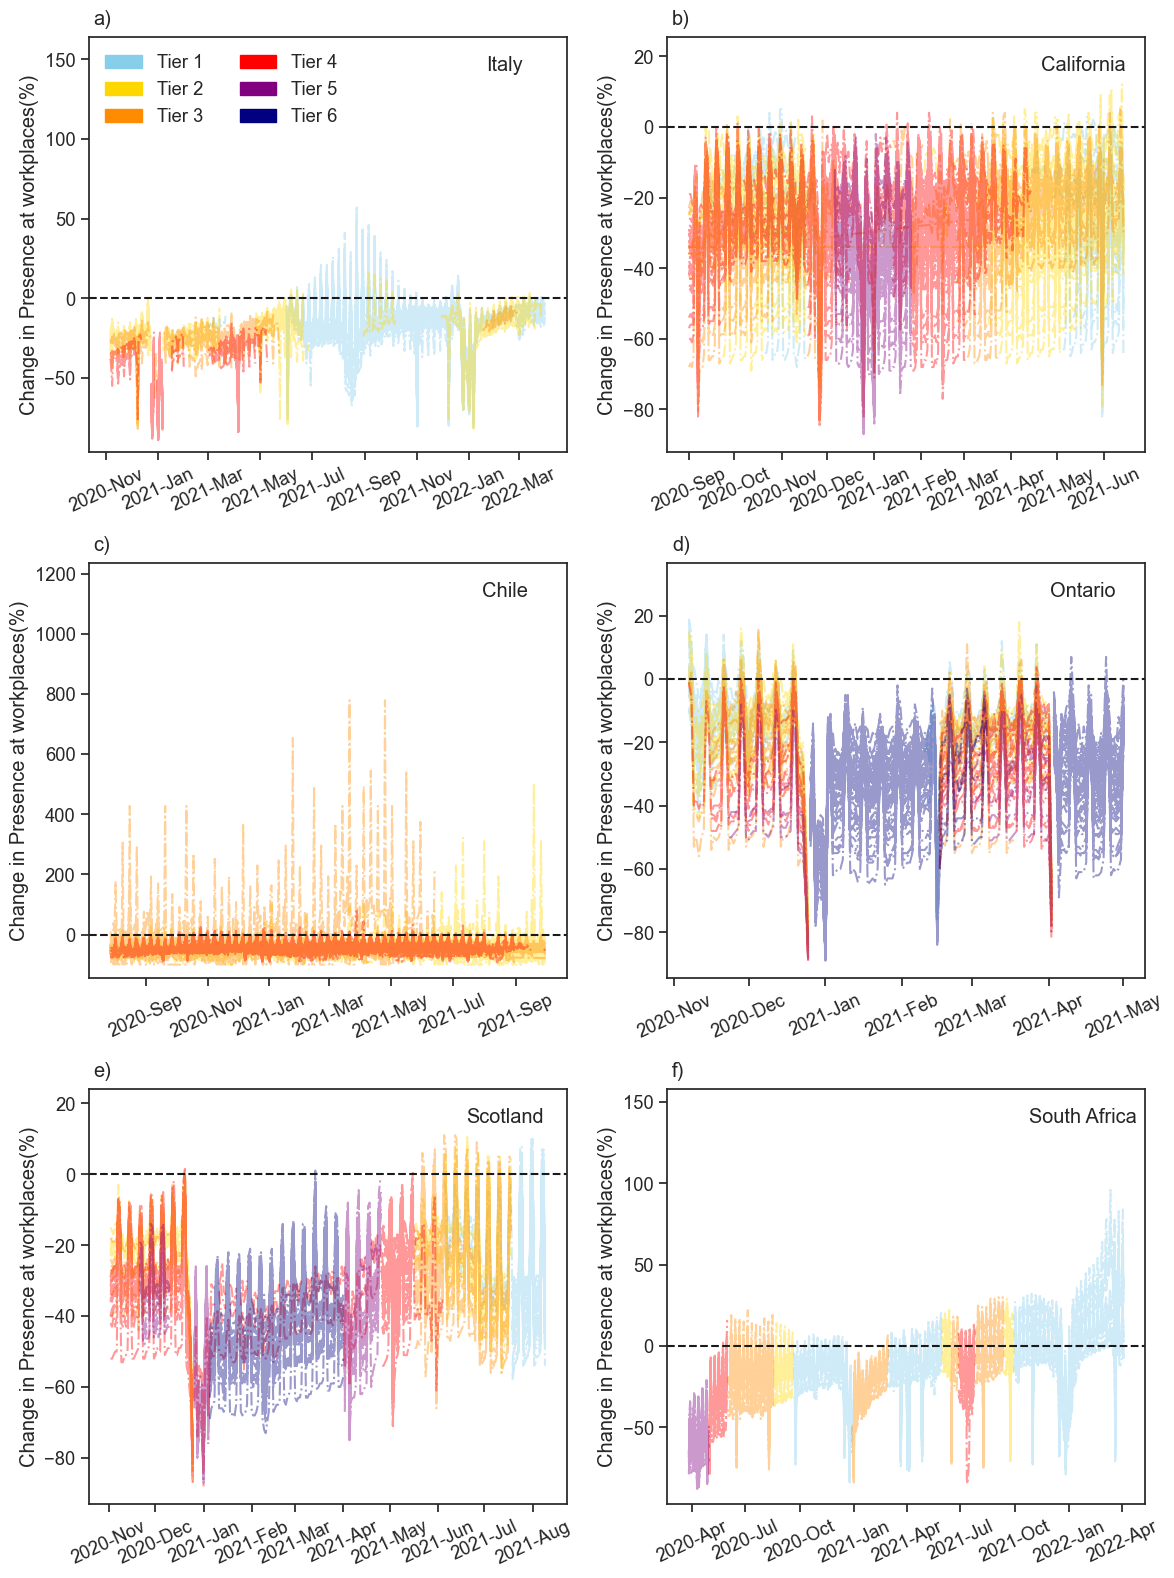

In [48]:
## Figure S1, timeline mobility 
tFigSize=(12,16)
sns.set(font_scale=1.2, style='ticks')  

DyLabel={'Residential':'Residential time', 'Workplaces':'Presence at workplaces'}
cmap = colors.ListedColormap(list(DColLev.values()))
bounds= np.arange(1,8)
norm = colors.BoundaryNorm(bounds,6)
DSpatialRes={'ITA':'Regions','ENG':'Local Authorities','SCO':'Council Areas','CA':'Counties', 'CHL':'Municipalities',
             'Ont':'Sub-Public Health Units', 'ZAF':'Provinces'}
lLabelPanel= ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)', 'h)', 'i)', 'l)', 'm)', 'n)']
sPlot = 'Mobility'

fig, ax = plt.subplots(nrows=3, ncols=2,figsize=tFigSize)
ax= ax.ravel()
# counter on panels
iPanel= 0
for sCnt in ['ITA','CA', 'CHL', 'Ont', 'SCO', 'ZAF']:
    sMob='Workplaces'
    # plot mobility data
    for iLevel in np.arange(1,DiLenLevels[sCnt]+1):
        if iLevel in DDfData['Google'][sCnt].Level.drop_duplicates().values:
            Dftemp= DDfData['Google'][sCnt][['Date','Level',sMob, 'TotDays']].copy()
            Dftemp.loc[Dftemp['Level']!= iLevel, sMob]=np.nan
            x=Dftemp['Date']
            y=Dftemp[sMob]
            ax[iPanel].plot(x, y, c=DColLev[iLevel], alpha=0.4, linestyle='-.')

    ax[iPanel].axhline(0, c='k', linestyle='--')
    # names geographical regions
    ax[iPanel].set_title(DNames[sCnt], x=0.87, y=0.9)
    
    # make space for title
    
    ax[iPanel].set_ylim((ax[iPanel].get_ylim()[0], ax[iPanel].get_ylim()[1]*1.5))

    ax[iPanel].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
    ax[iPanel].tick_params('x',labelrotation=25)
    ax[iPanel].set_xlabel('')

    # label subplot
    ax[iPanel].text(s=lLabelPanel[iPanel], x=0.01, y=1.03, transform=ax[iPanel].transAxes)

     # labels only on the first column
    
    ax[iPanel].set_ylabel('Change in '+DyLabel[sMob]+ '(%)')
   
    iPanel+= 1


# make space for legend/title
ax[0].set_ylim((ax[0].get_ylim()[0], ax[0].get_ylim()[1]*1.7))
hands = [ mpatches.Patch(color=DColLev[l], label="Tier "+str(l)) for l in np.arange(1,7)]
ax[0].legend(handles=hands , ncol=2,  loc=2, frameon=False)

plt.tight_layout()
fig.savefig('../../Figures/Adherence/SI/Figure_S1.png', dpi=120)

plt.show()


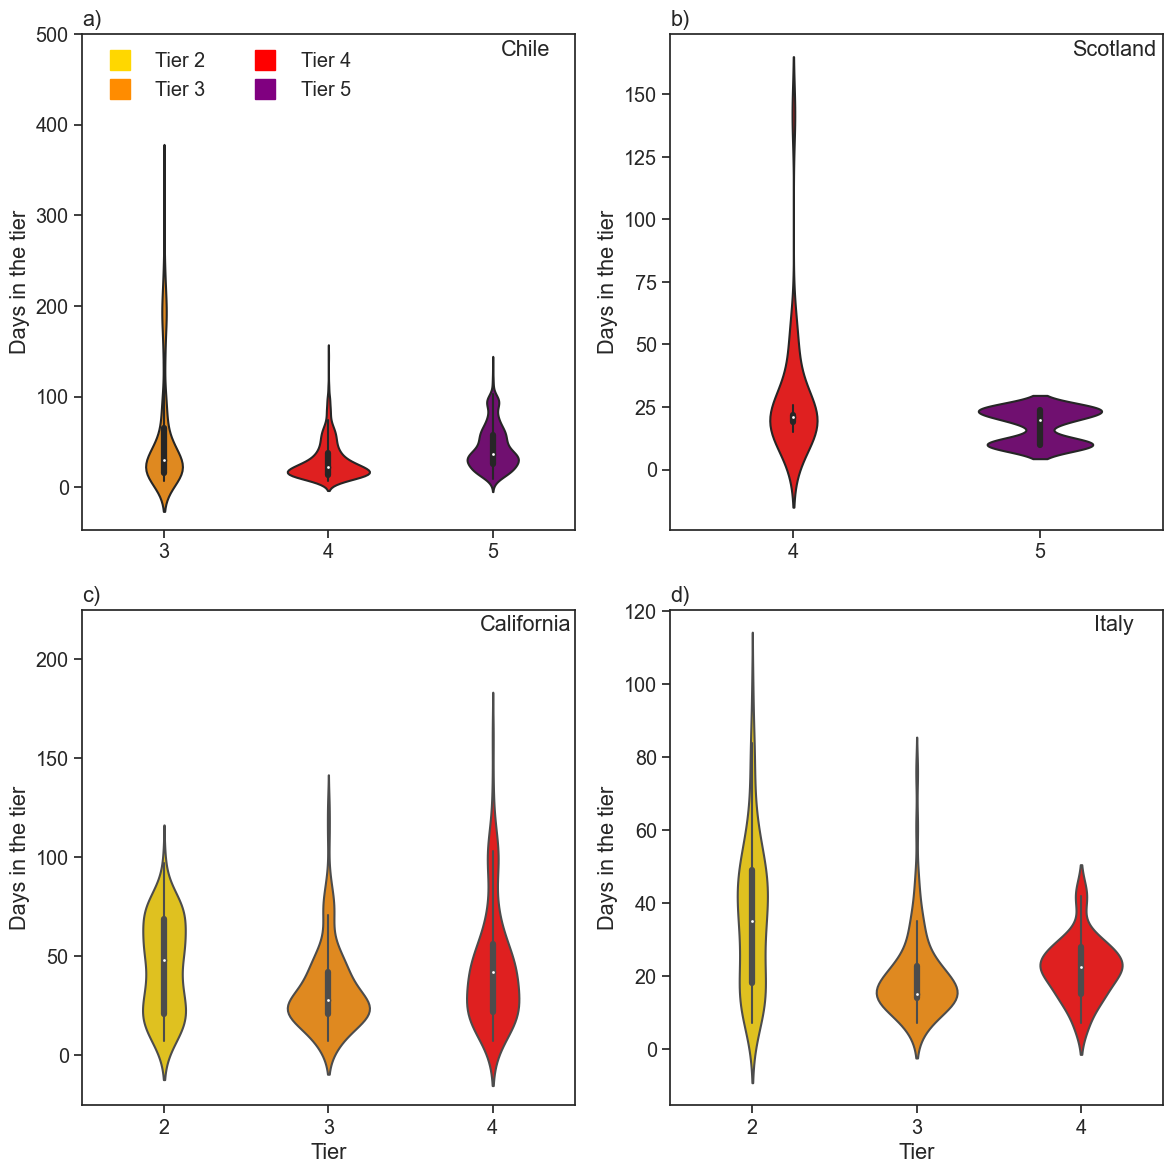

In [16]:
# Observed pattern of implementation
DxLine={'Workplaces':1, 'Residential':-1}
sns.set(font_scale=1.3 ,style='ticks')
DsMobType={'Residential':'time', 'Workplaces':'presence'}
DNamesLongToShort= dict(zip(list(DNames.values()),list(DNames.keys())))
DColAll={'Global':'k', 1: 'skyblue', 2: 'gold', 3: 'darkorange', 4: 'red', 5: 'purple'}
lLabelPanel= ['a)', 'b)', 'c)', 'd)']

sMob= 'Residential'
fig, ax = plt.subplots(2,2,figsize=(12,12))
ax=ax.ravel()
for iCnt, sCnt in enumerate(['Chile', 'Scotland', 'California', 'Italy',]):
           
        aOcc= np.arange(6)
        aLev=DfResMod.sort_index().loc['Google',sMainModel,sCnt,'Slope','Iteration fatigue'].index.droplevel(0).values
        aLev=aLev[aLev>0]
        iDays=130
        aDays= np.arange(1,iDays)
        hand=[] 
        labe=[]
        
        idxLevOcc=np.where((abs(DfResMod.loc['Google',sMainModel,sCnt,'Slope','Iteration fatigue',:,:][sMob,'Est. '+sMob])>\
                abs(DfResMod.loc['Google',sMainModel,sCnt,'Slope','Iteration fatigue',:,:][sMob,'CI95% '+sMob])).values==True)[0]
        lLevFigOcc=list((abs(DfResMod.loc['Google',sMainModel,sCnt,'Slope','Iteration fatigue',:,:][sMob,'Est. '+sMob])>\
                abs(DfResMod.loc['Google',sMainModel,sCnt,'Slope','Iteration fatigue',:,:][sMob,'CI95% '+sMob])
                ).iloc[idxLevOcc].droplevel(0).index.values)
       
        idxLevLoc=np.where((abs(DfResMod.loc['Google',sMainModel,sCnt,'Slope','Tier fatigue',:,:][sMob,'Est. '+sMob])>\
                abs(DfResMod.loc['Google',sMainModel,sCnt,'Slope','Tier fatigue',:,:][sMob,'CI95% '+sMob])).values==True)[0]
        lLevFigLoc=list((abs(DfResMod.loc['Google',sMainModel,sCnt,'Slope','Iteration fatigue',:,:][sMob,'Est. '+sMob])>\
                abs(DfResMod.loc['Google',sMainModel,sCnt,'Slope','Iteration fatigue',:,:][sMob,'CI95% '+sMob])
                ).iloc[idxLevLoc].droplevel(0).index.values)
        lTierPlot=lLevFigLoc+ lLevFigOcc
        lTierPlot.sort()        
            
        ### Violin plot for the median duration of each tier
        if lTierPlot:
            DftempVio=DDfData['Google'][DNamesLongToShort[sCnt]][['Region','Level','NOccurrence','T_Level']].copy()
            DftempVio=DftempVio[(DftempVio['T_Level']>=7) & (DftempVio['NOccurrence']>=1)]
            DftempVio=DftempVio.groupby(['Region','Level','NOccurrence']).max().loc[idx[:,lTierPlot],].reset_index()
            fBarLev=sns.violinplot(x='Level',y='T_Level', data=DftempVio, palette=DColLev, dodge=True , 
                             estimator='mean', errwidth=1.5, ax=ax[iCnt], width=0.5)   
            DLines=dict(DftempVio.groupby('Level').mean(numeric_only=True)['T_Level'])      
        
        ax[iCnt].set_ylabel('Days in the tier')
        ax[iCnt].set_title(lLabelPanel[iCnt], loc='left')
        ax[iCnt].set_title(sCnt,y=0.94, x=0.9)


        if iCnt in range(2):    
            ax[iCnt].set_xlabel('')
        else:
            ax[iCnt].set_xlabel('Tier')
    
        ax[iCnt].legend([],[], frameon=False)
        ax[iCnt].legend([],[], frameon=False)
    
ax[0].set_ylim(ymax=500)
ax[2].set_ylim(ymax=225)


lCols=list(DColAll.values())[2:]
hand=[mlines.Line2D([], [], color=col, marker='s', linestyle='', markersize=15) for col in lCols]
lab=['Tier '+lev for lev in ['2','3','4','5']]

ax[0].legend(ncol=2, handles=hand, labels=lab, frameon=False, loc=2)
ax=ax.reshape([2,2])
fig.tight_layout()

fig.savefig('../../Figures/Adherence/SI/Figure_S14.png', dpi=120)


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_1787/3387204325.py:29: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


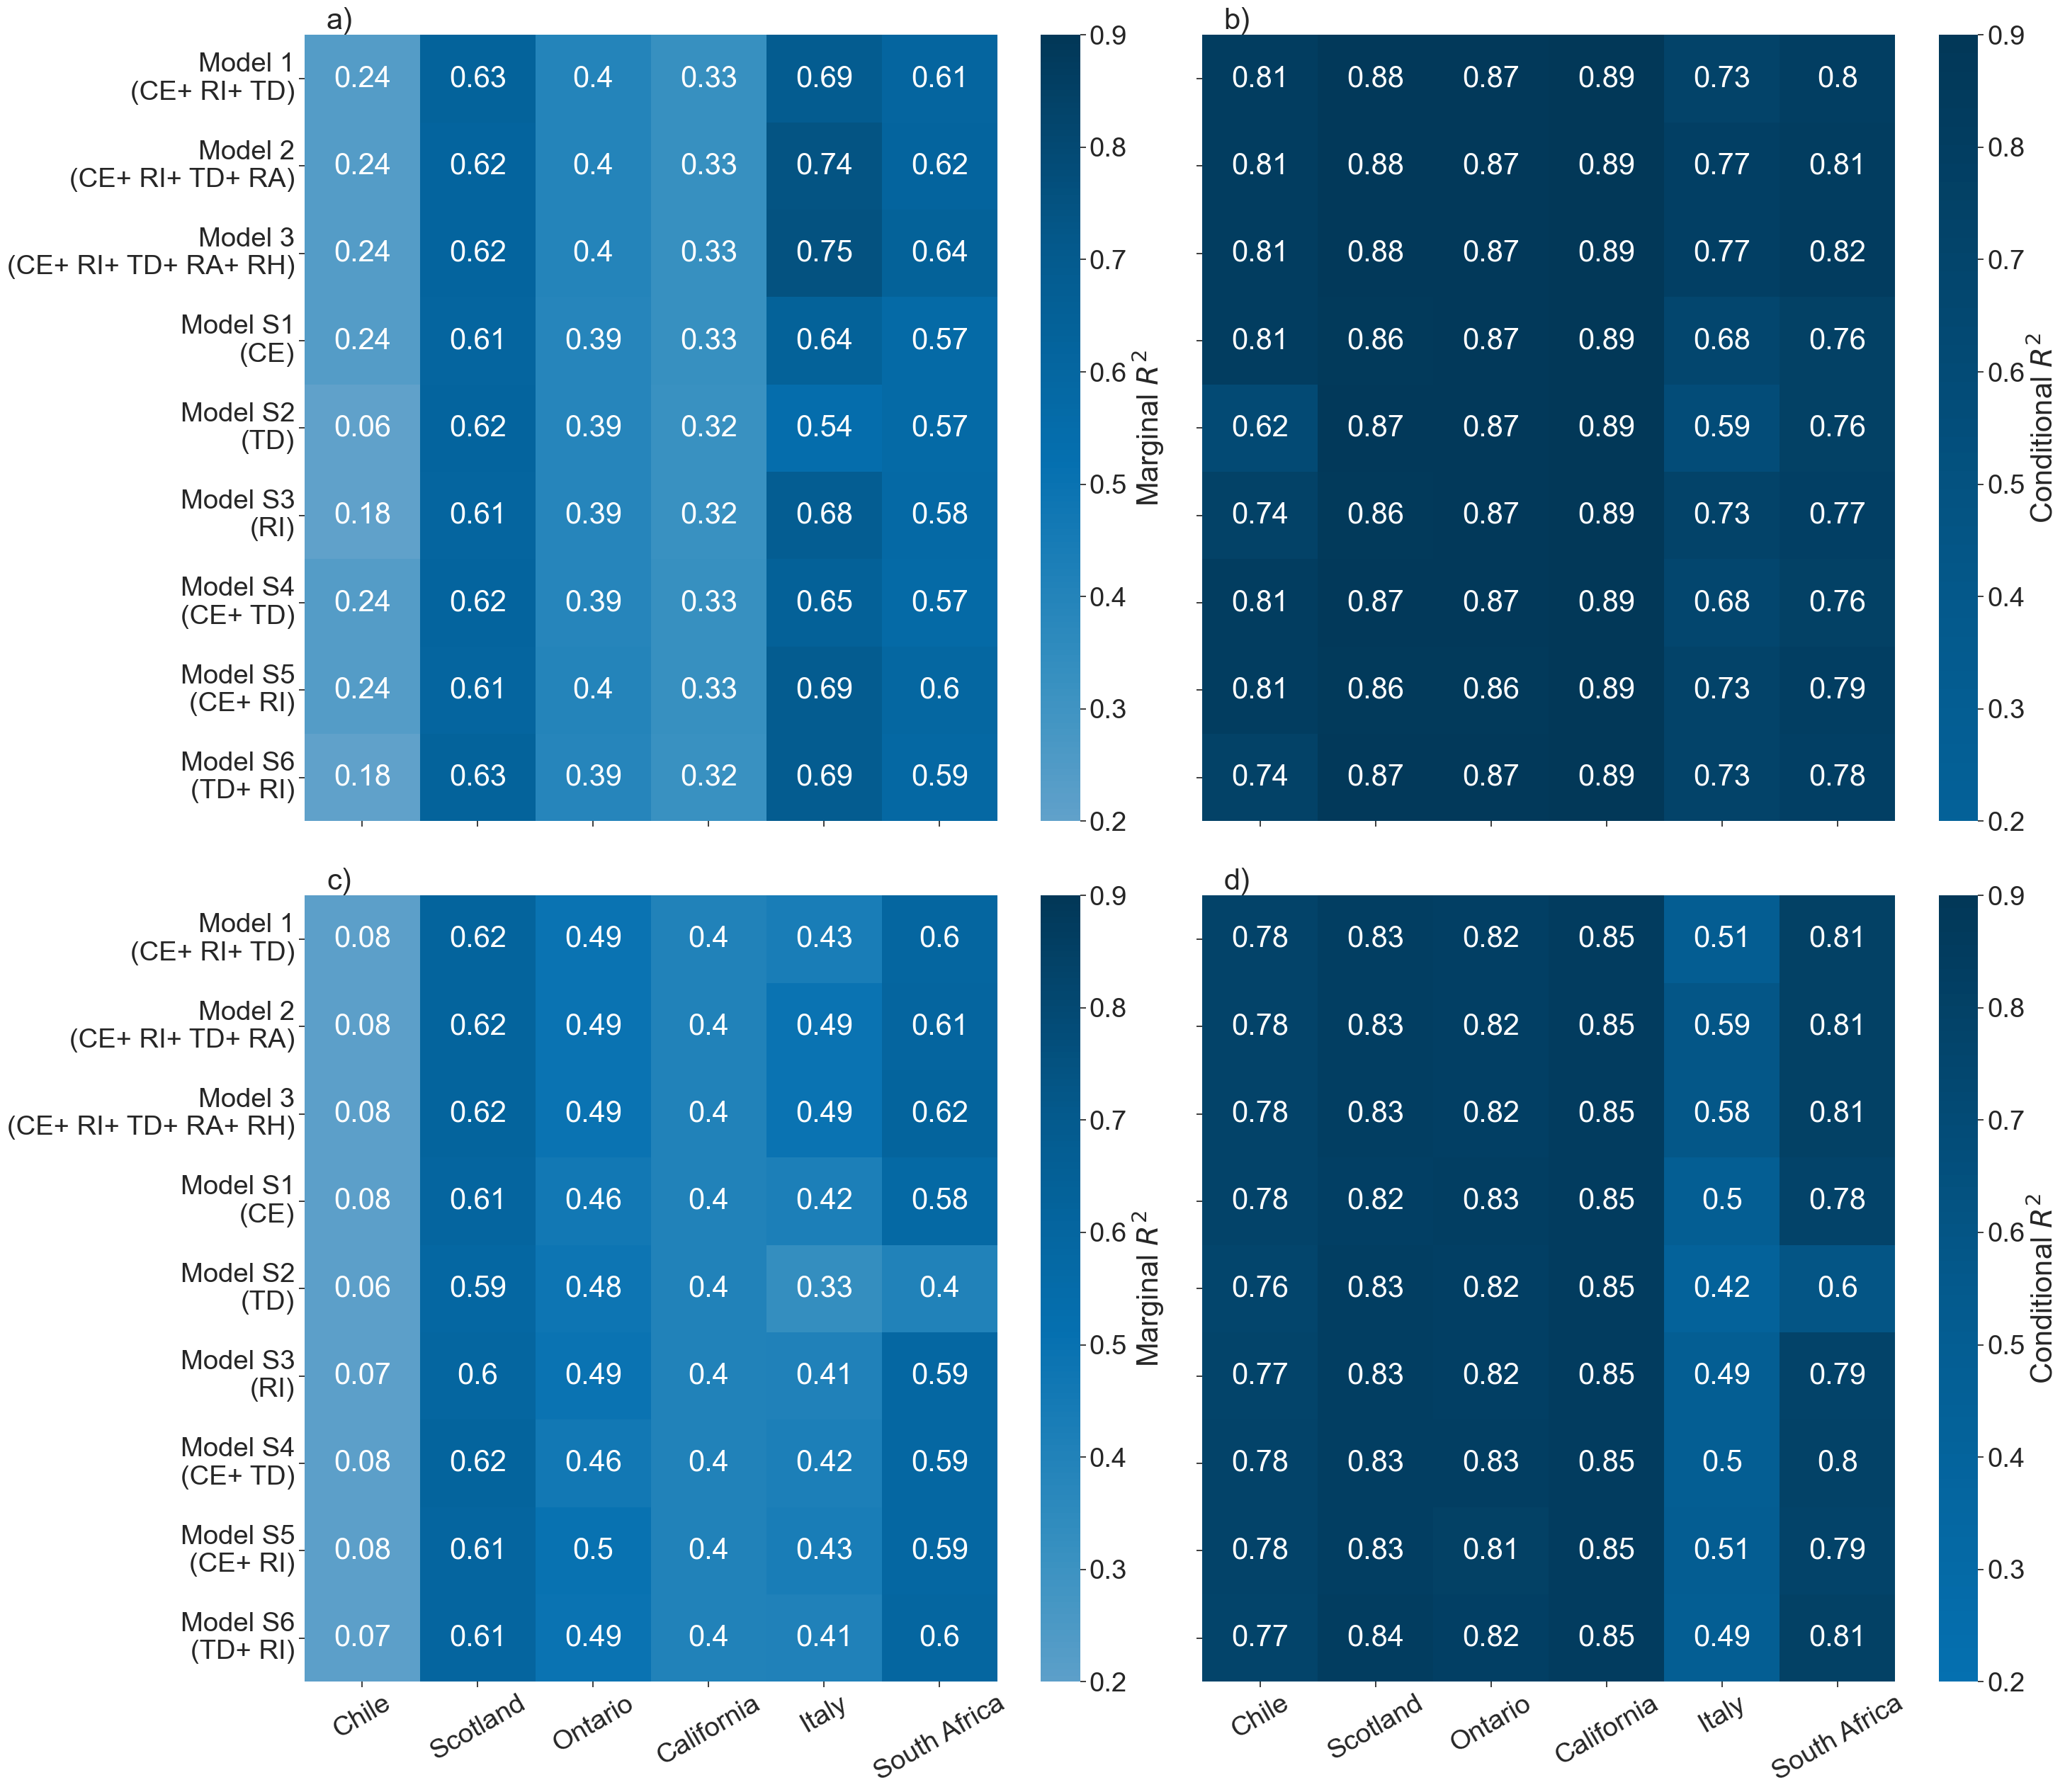

In [16]:
# R2 Heatmap
tFigSize=(30,26)
sns.set(font_scale=2.5, style='ticks') 
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=tFigSize, sharey=True, sharex=True)
ax=ax.ravel()
iCount=0
DsStat={'m':'Marginal ', 'c':'Conditional '}
lnumsbplot= ['a', 'b', 'c', 'd']

for sMob in ['Residential','Workplaces']:
    for sStat in ['m','c']:
   
        Df=DfResMod.loc[idx['Google',lSortModel[::-1],:,sStat+'R2'],(sMob)].dropna(axis=1).droplevel([0,3,4,5,6]
                ).reindex(labels=lRegSort, level=1).unstack()['Est. '+sMob].iloc[::-1]    
        norm = plt.Normalize(0.2,0.9)
        iMax=Df.max().max()
        sns.heatmap(Df, center=0, cmap='PuBu', annot=True,ax=ax[iCount], 
                    cbar_kws={'label':DsStat[sStat]+ r'$R^2$'},
                     norm=norm)
             
        ax[iCount].set(xlabel='', ylabel='')   
        
        lLaby= [DLabMod[iMod]+'\n'+ DLabelsShort[iMod] for iMod in lSortModel]
        ax[iCount].set_yticklabels( labels=lLaby)
        ax[iCount].tick_params(axis='x', labelrotation=30)
        ax[iCount].set_title(lnumsbplot[iCount]+')', x=0.05)

        iCount+=1
    fig.tight_layout()
    fig.savefig('../../Figures/Adherence/Revision2/SI/HeatMap_R2.png', dpi=120)


In [22]:
# Plots panels all models

#pf.fFig_OTF_AllMod(DfResMod, sData, iTimePeriod)
#pf.fFig_RTF_Panel(sData,DfResMod, DlMob[sData][:3:-1], DColLev,iTimePeriod, bHoly, bWeekend)
#pf.fFig_ItF_Panel(DfResMod, DColLev)


/Users/albano/Desktop/Ricerca/EPIcx/Code/Adherence/PlotFunctions.py:1291: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  Df= Df.drop(columns=['Data', 'Parameter type', 'Original name','Level']).set_index(['Region', 'Parameter','Model']).reindex(lRegSort, level=0)
/Users/albano/Desktop/Ricerca/EPIcx/Code/Adherence/PlotFunctions.py:1300: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  Df=Df.stack().stack().sort_index().loc[idx[:,:,:,['Down','Up','Est. Residential','Est. Workplaces']],].to_frame().reset_index().rename(
/Users/albano/Desktop/Ricerca/EPIcx/Code/Adherence/PlotFunctions.py:1302: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What

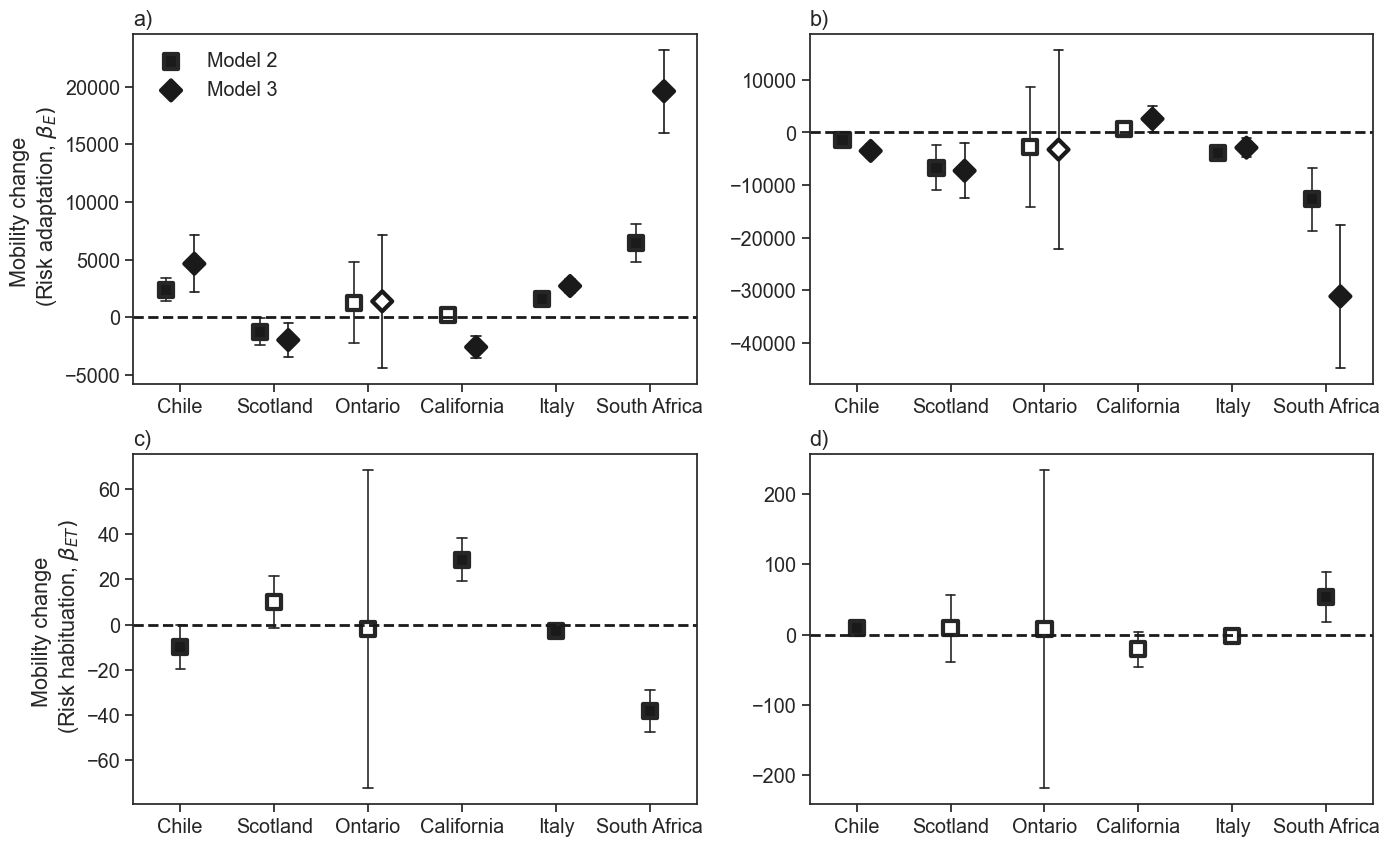

In [24]:
# risk perception estimates
pf.fRiskPerception(DfResMod)

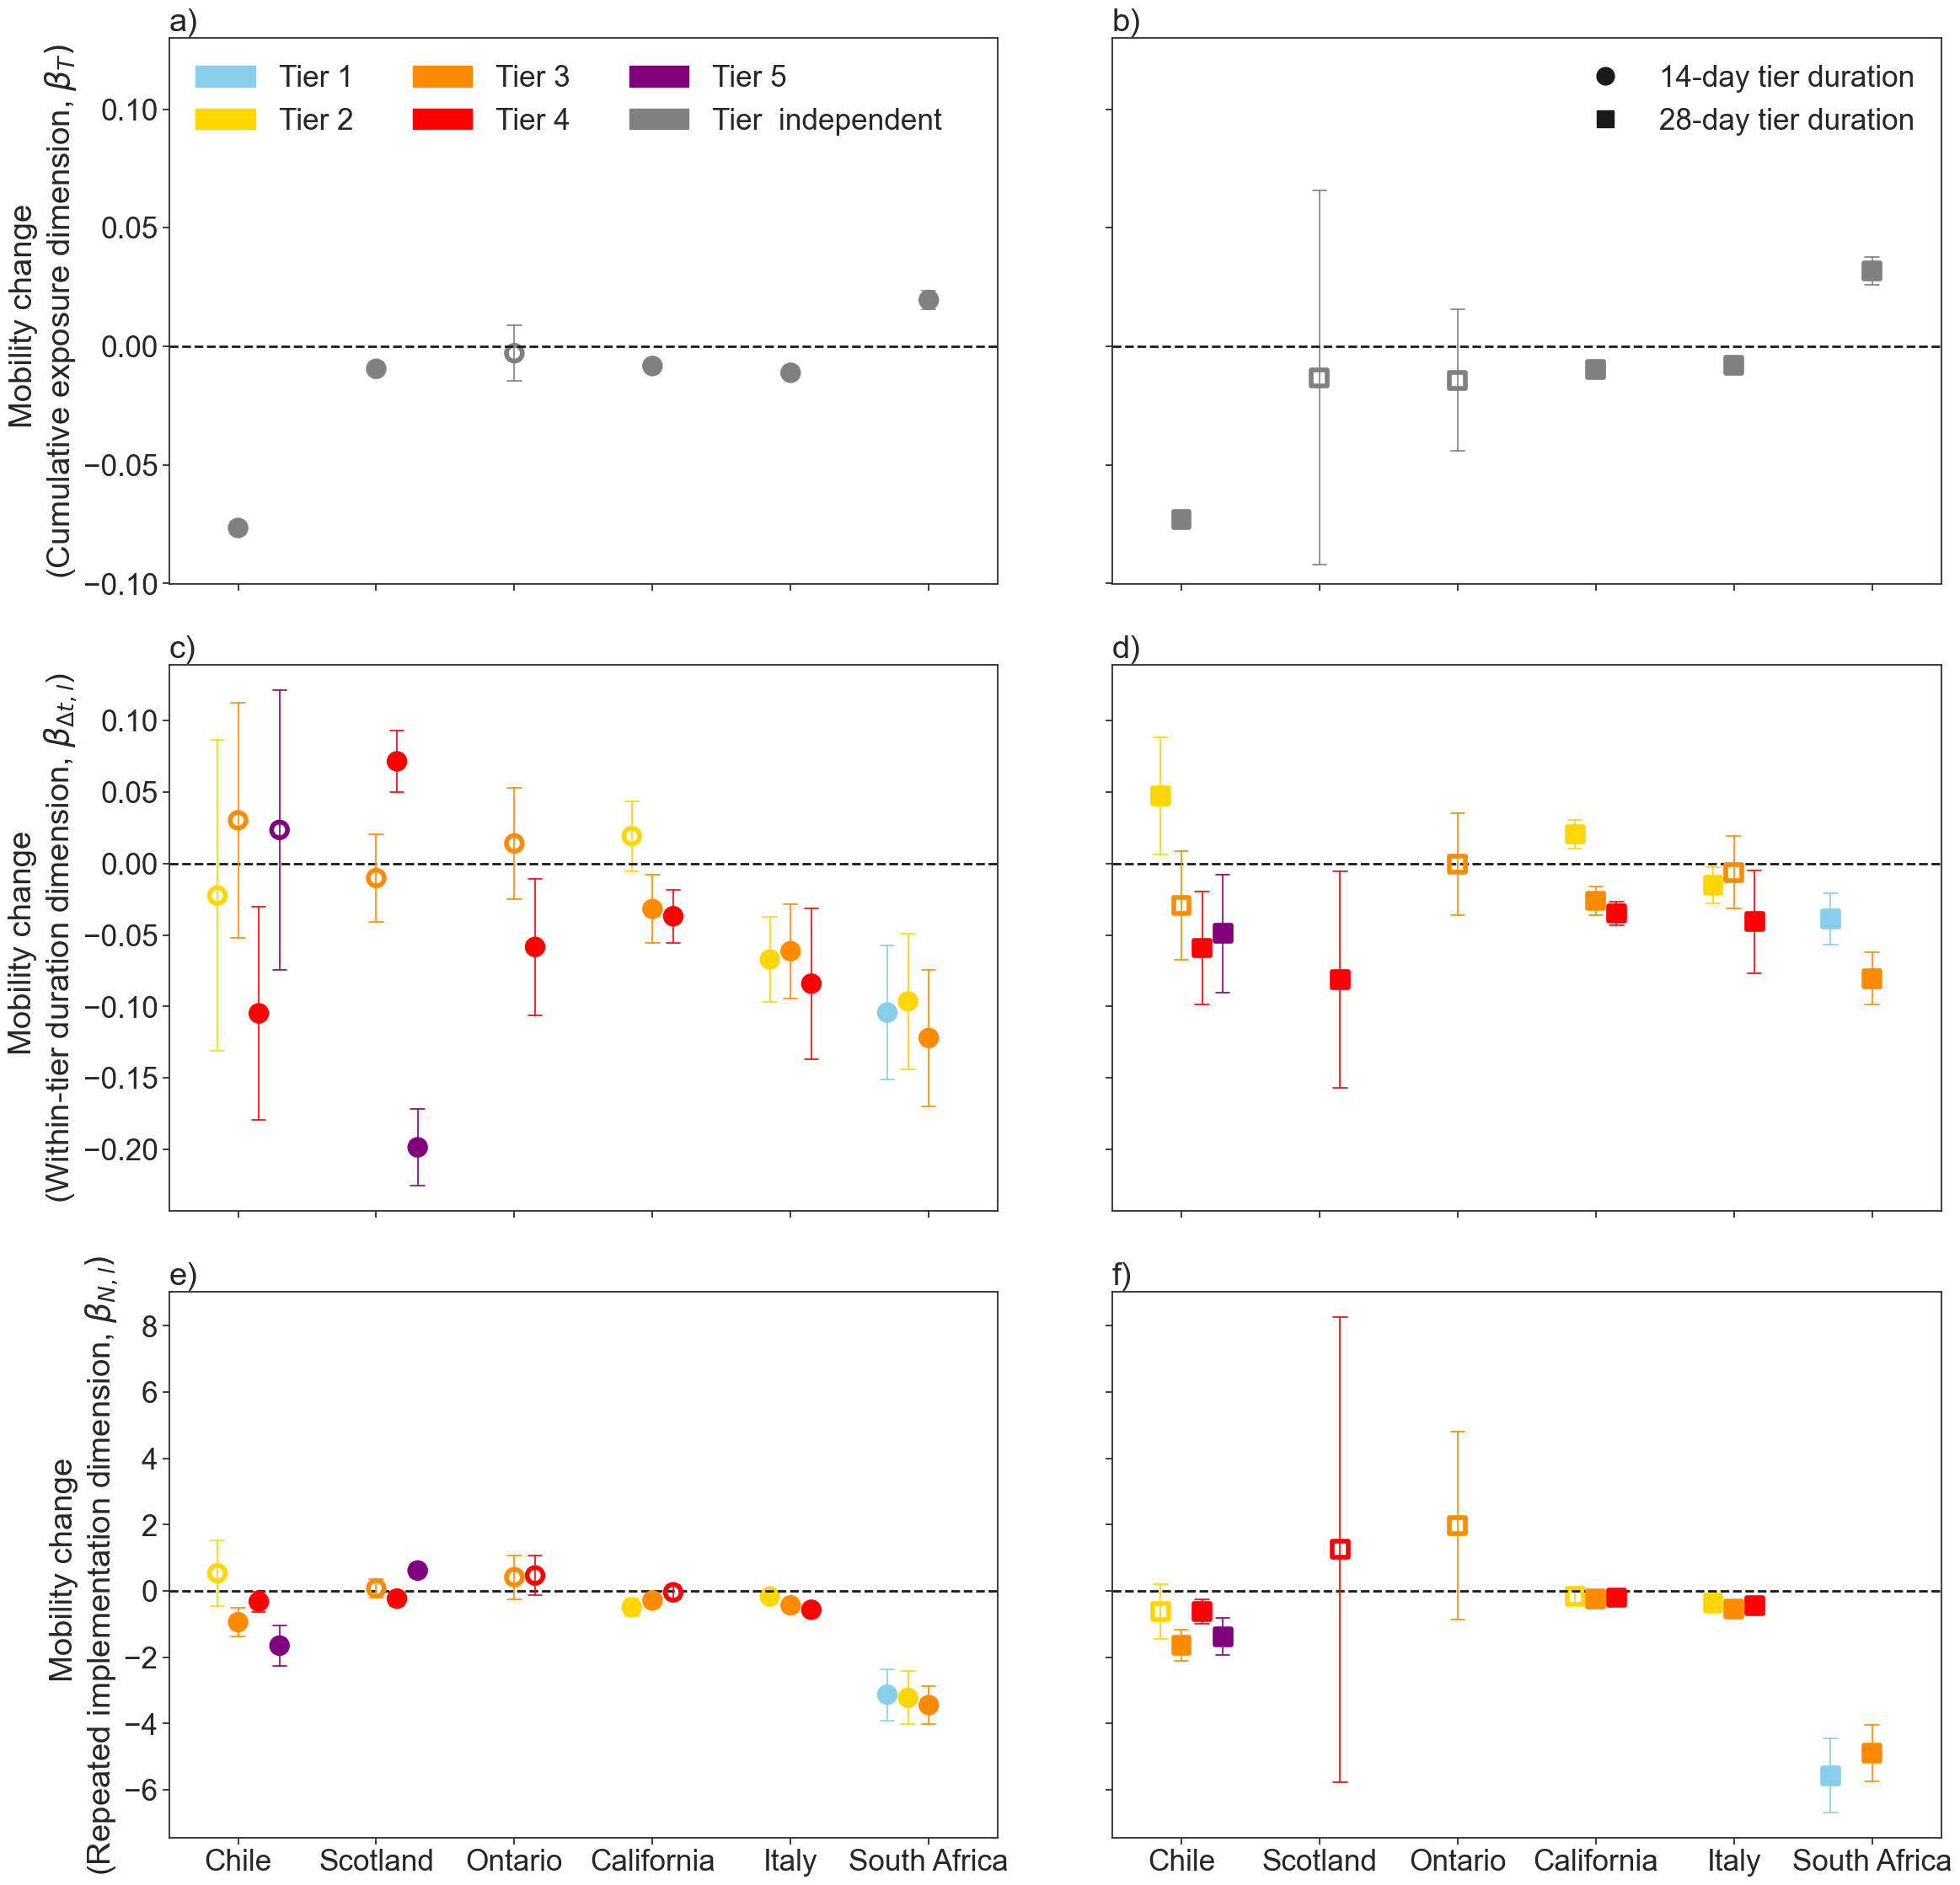

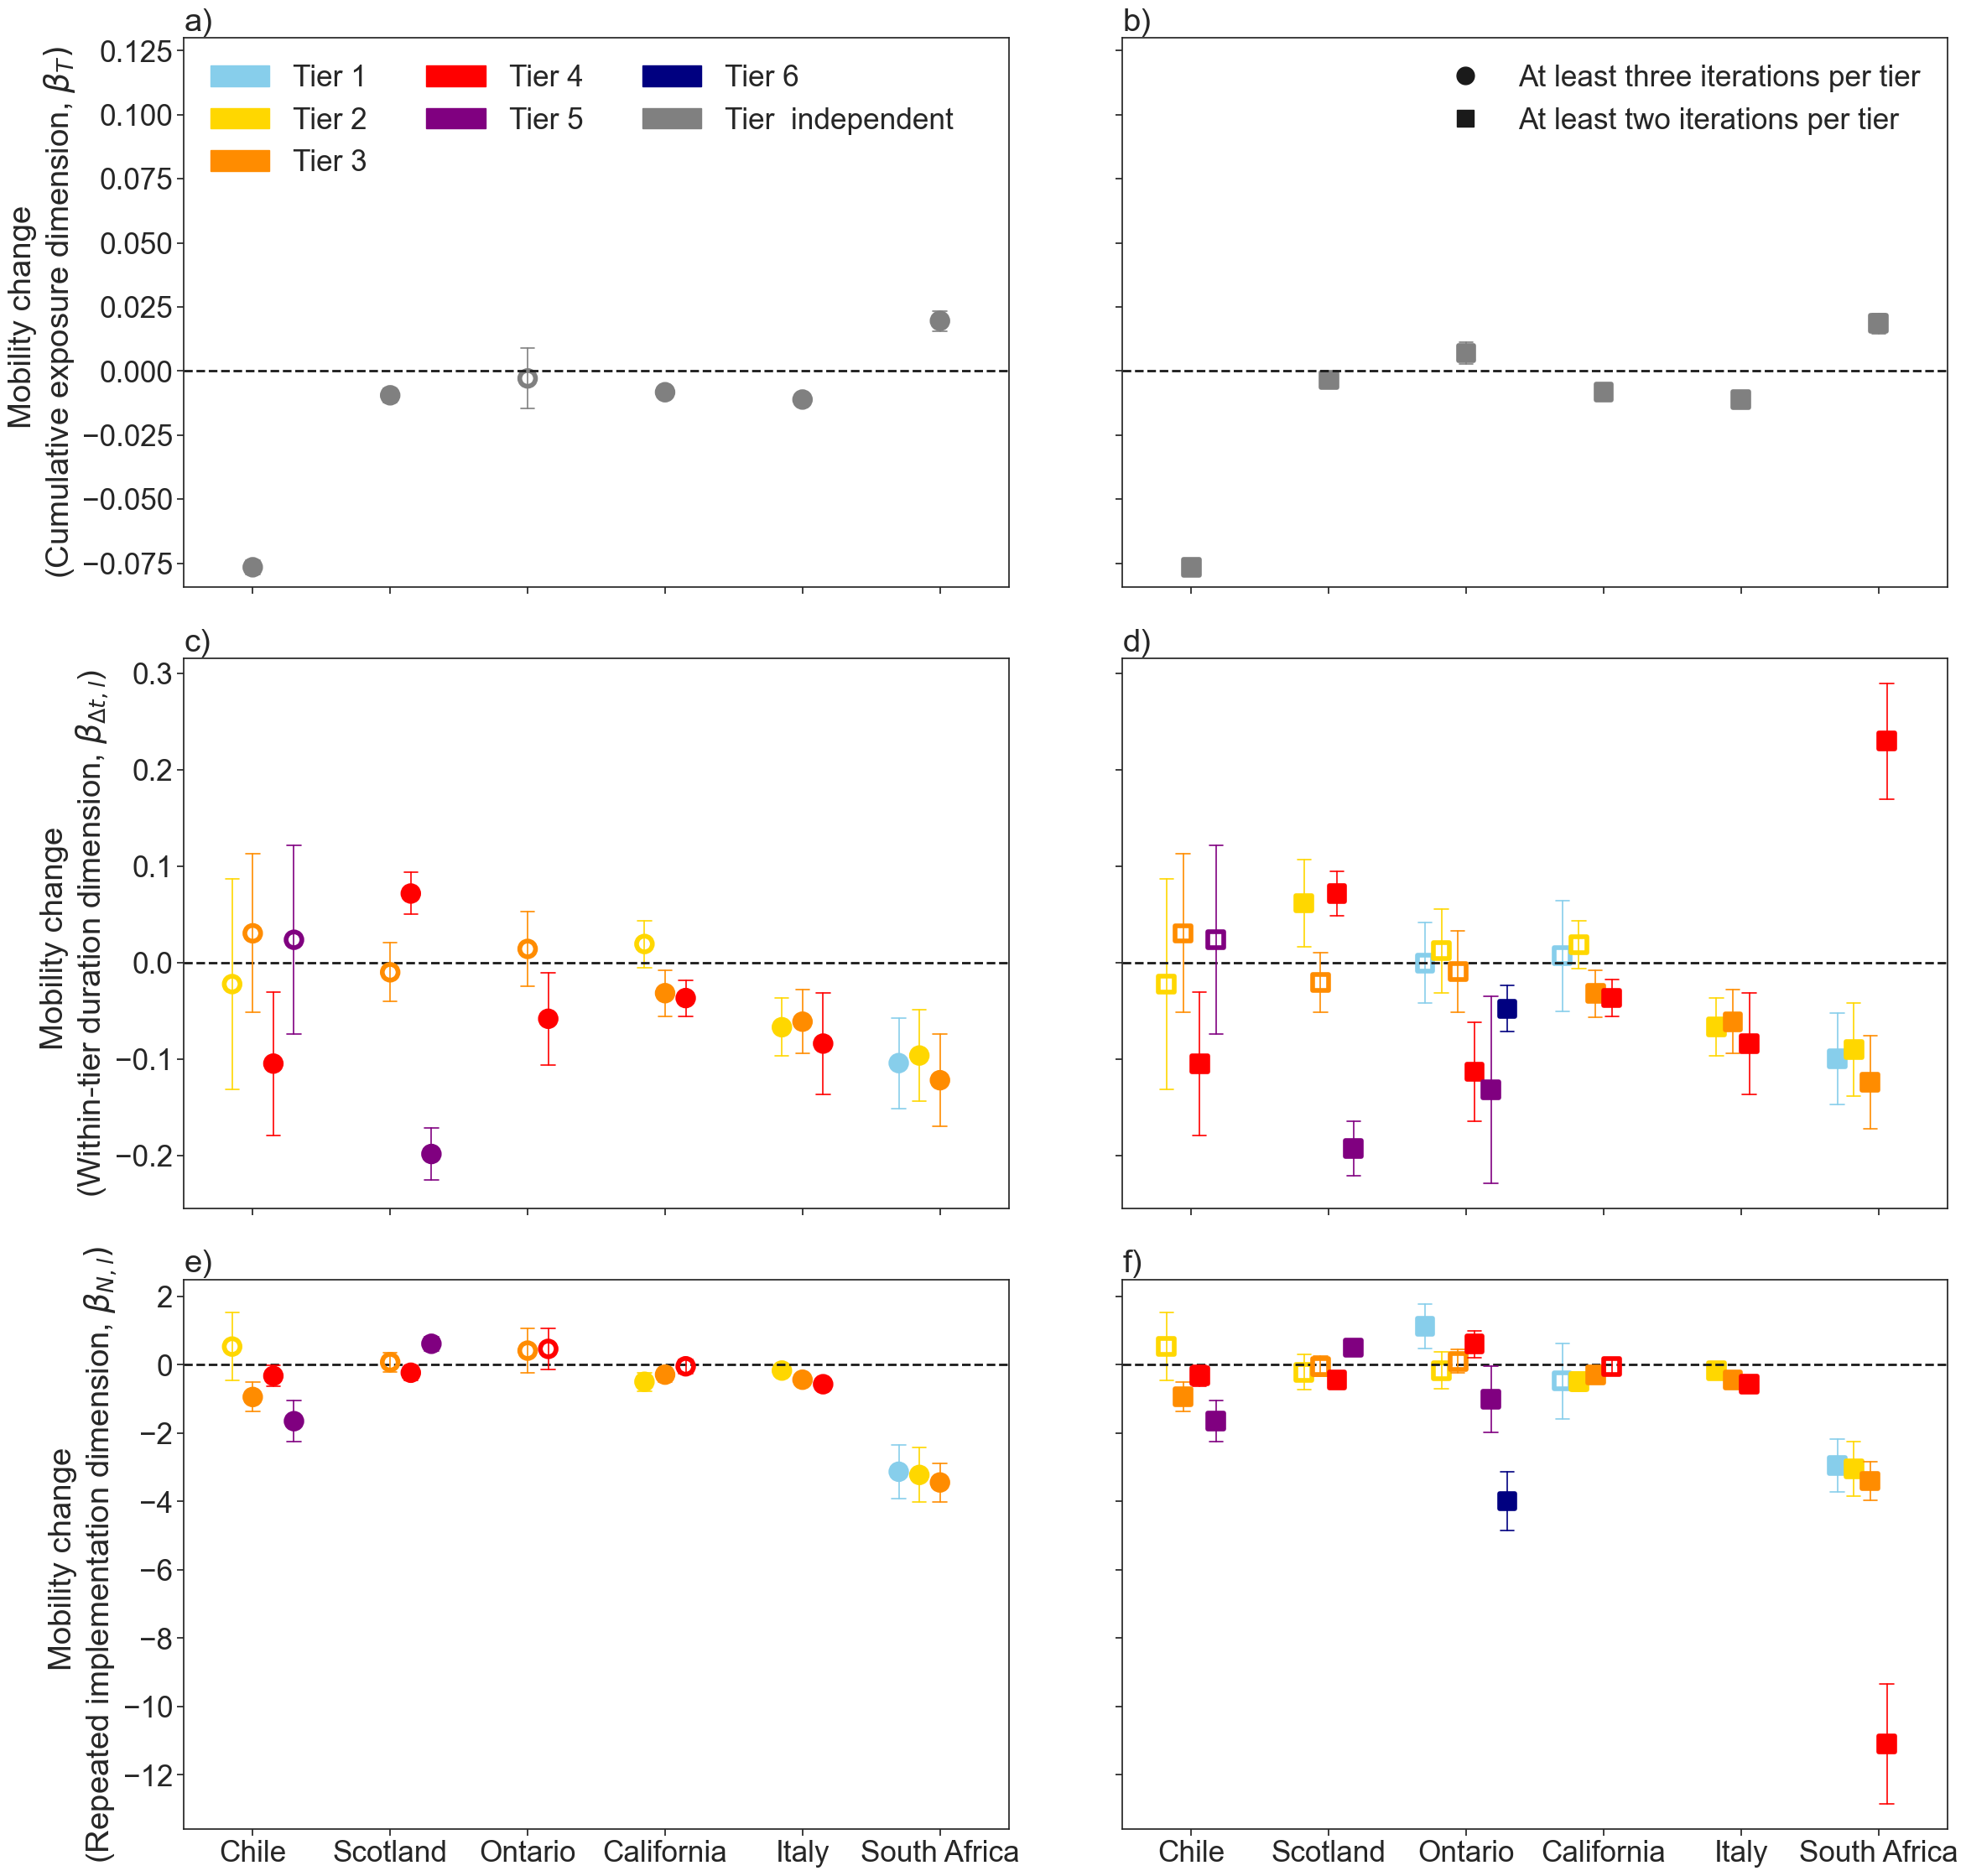

In [28]:
# sensitivity number of iterations 

for sSensitivity in ['Duration','Iteration']:
    pf.fFig_Sensitivity(DfResMod, DColLev, sSensitivity, sMainModel)


/opt/anaconda3/envs/E_Adherence/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/E_Adherence/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/E_Adherence/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/E_Adherence/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

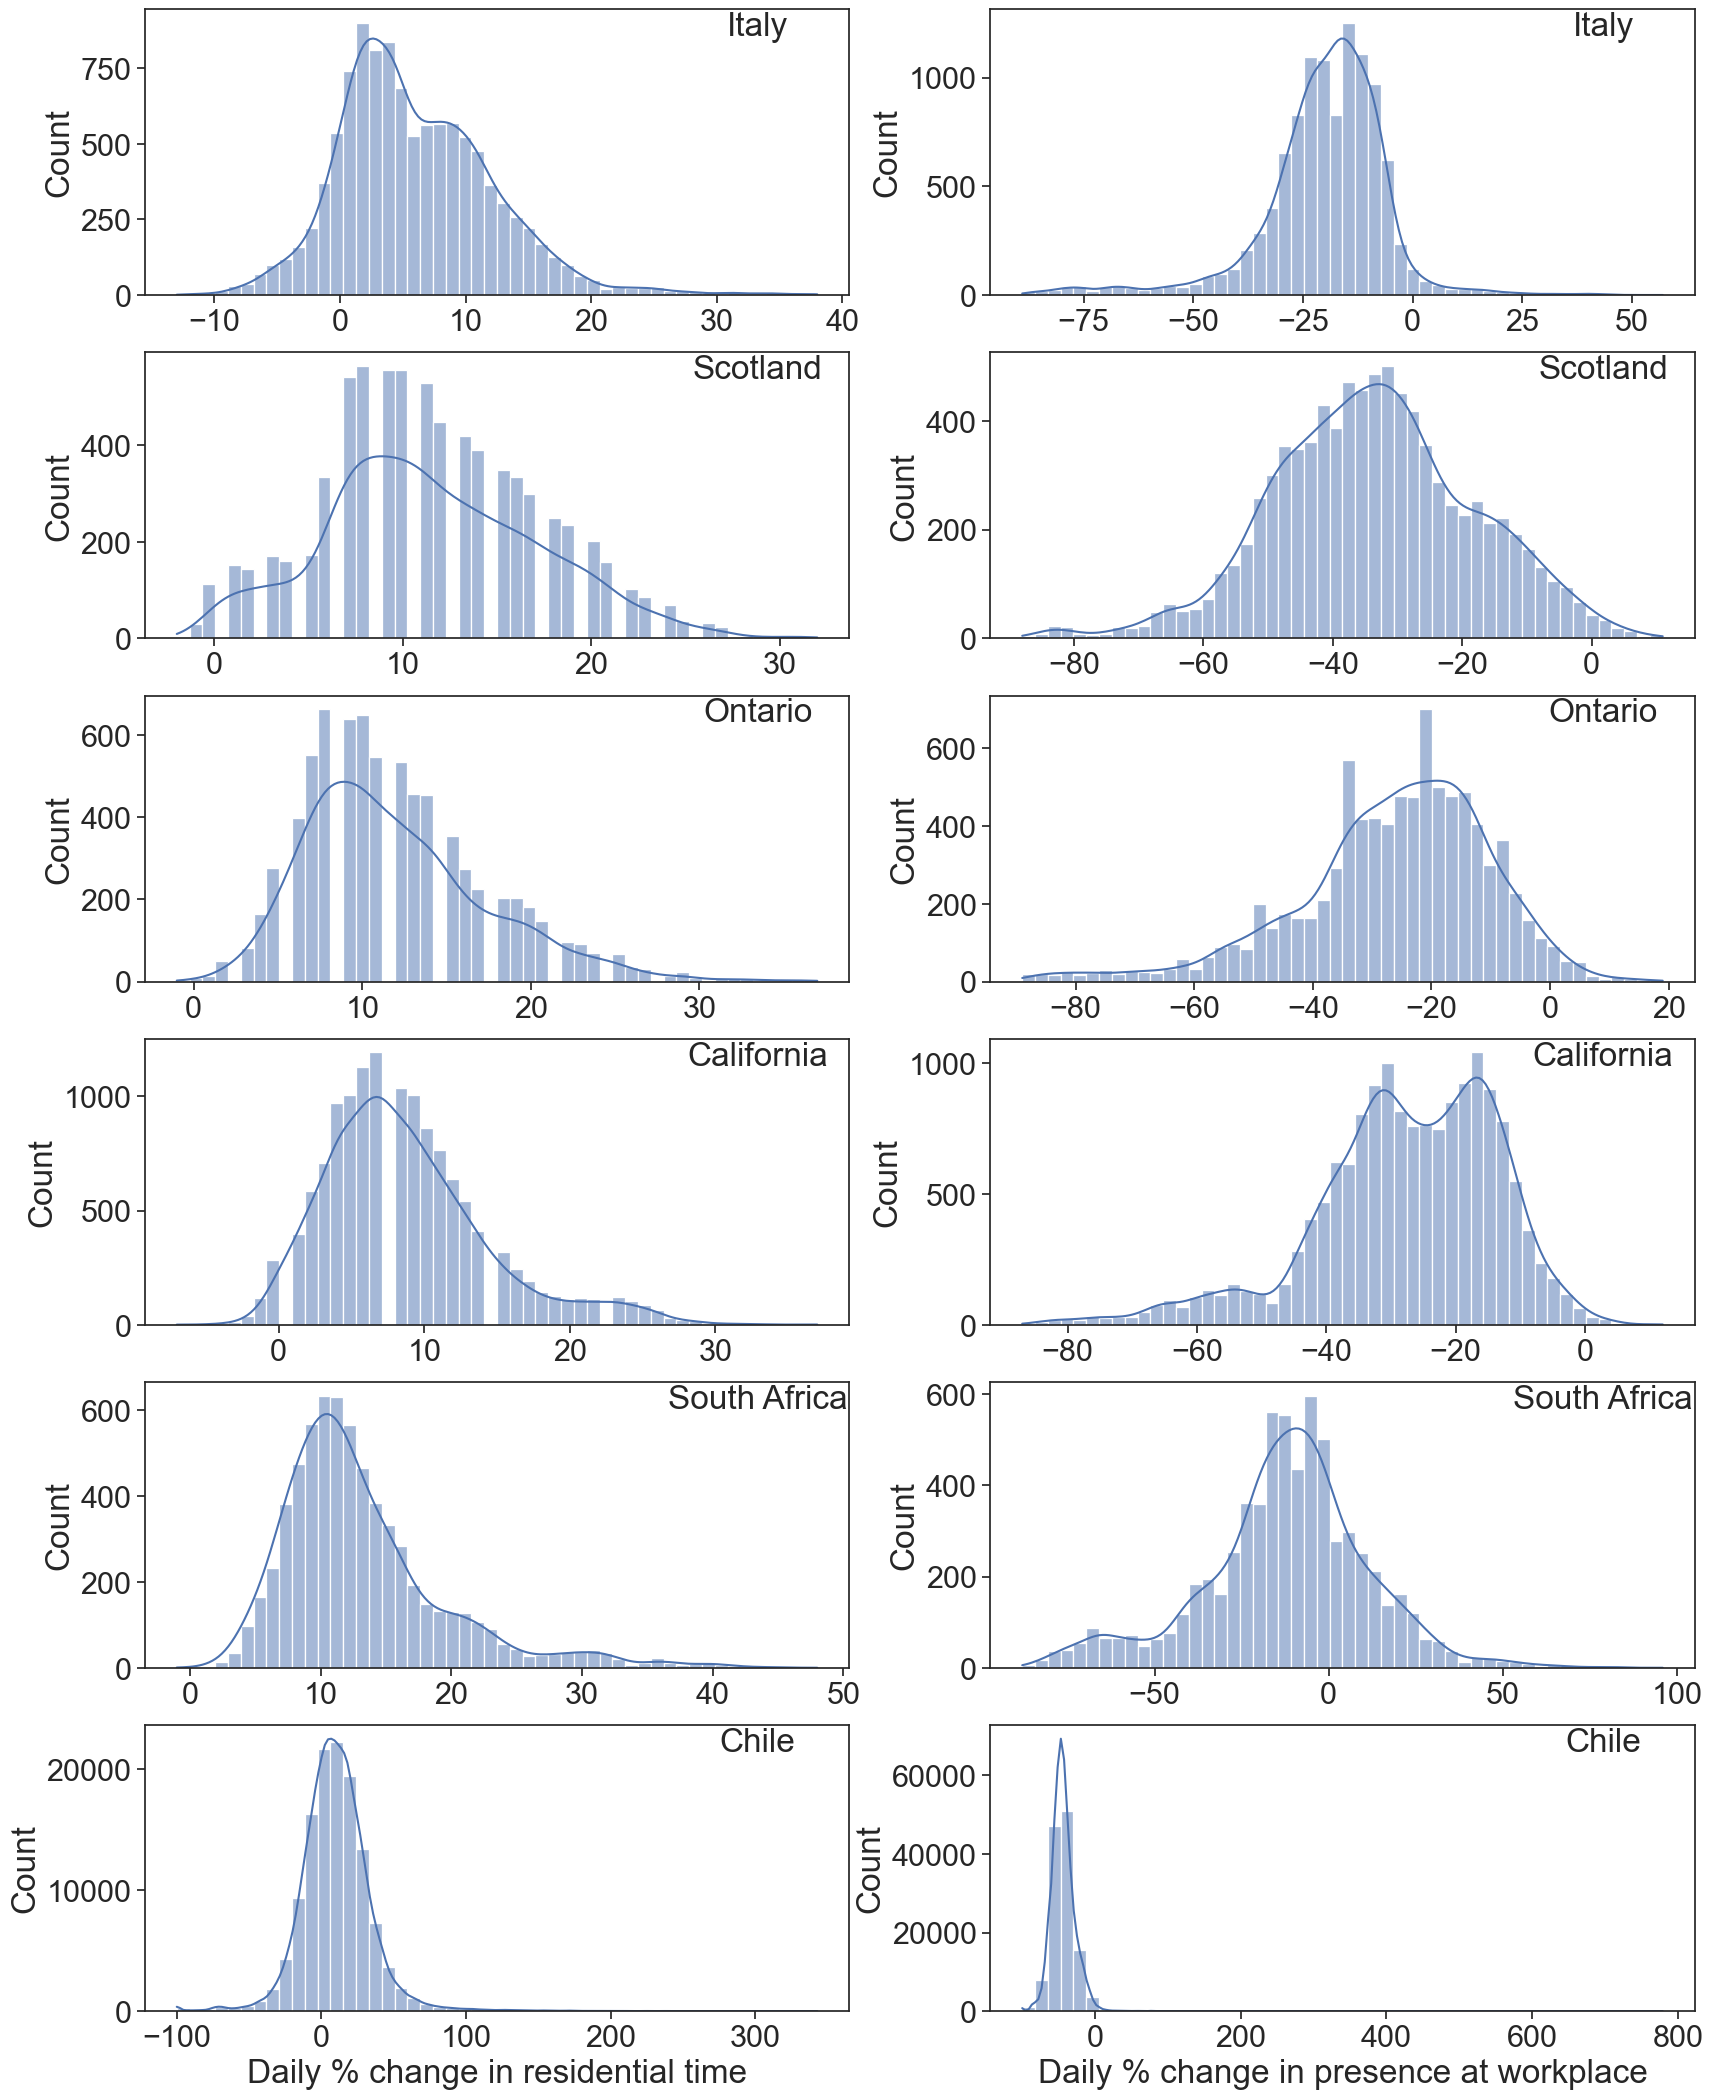

In [80]:
## norm distribution for fit
tFigSize=(20,26)
iFontSize=(tFigSize[1]/tFigSize[0])*(1)
sns.set(font_scale=2, style='ticks')  
DlabMob= {'Residential': 'residential time', 'Workplaces': 'presence at workplace'}
fig, ax = plt.subplots(nrows=6, ncols=2,figsize=tFigSize)
ax= ax.ravel()
iPanel =0
for sCnt in ['ITA','SCO', 'Ont', 'CA', 'ZAF', 'CHL']:
    for sMob in ['Residential', 'Workplaces']:
        sns.histplot(data=DDfData['Google'][sCnt], x=sMob, ax=ax[iPanel], bins=50, kde=True)
    
        if iPanel in [10,11]:
            ax[iPanel].set_xlabel('Daily % change in '+DlabMob[sMob])
        else:
            ax[iPanel].set_xlabel('')
        ax[iPanel].set_title(DNames[sCnt], y=0.88, x=0.87)

        iPanel+=1

fig.savefig('../../Figures/Adherence/SI//Panel_MobDist.png', dpi=120)

plt.show()

In [ ]:
# implementation distribution plot
tFigSize=(10,12)
sns.set(font_scale=1.5, style='ticks')  
fig,ax = plt.subplots(1, figsize= tFigSize)

# distribution implementation duration across tiers and regions
Dftemp= pd.concat([DDfData['Google'][sCnt][['Region', 'Level', 'NOccurrence','T_Level']] for sCnt in ['ITA','SCO', 'Ont', 'CA', 'ZAF', 'CHL']])
Dftemp= Dftemp.sort_values(by=['Region', 'Level', 'NOccurrence','T_Level']).drop_duplicates(
    ['Region', 'Level', 'NOccurrence'], keep='last')

sns.histplot(x='T_Level', data=Dftemp, ax=ax)

ax.axvline(14, c='k', linestyle='--')
ax.axvline(Dftemp['T_Level'].median(), c='r', linestyle='--')
ax.set(xlabel='Duration of each tier implementation (Days)', ylabel='Count of implementations')
hands= [mlines.Line2D([], [], color=col, linestyle='--') for col in ['k','r']]
labs= ['Choosen duration', 'Median duration']
ax.legend(handles=hands ,labels=labs, ncol=1, loc=1,  frameon=False)

fig.savefig('../../Figures/Adherence/SI/TierDuration_Distribution.png', dpi=120)
# distribution,median duration implementation across  regions
"""
fig,ax = plt.subplots(1, figsize= tFigSize)

Dftemp= Dftemp.groupby(['Level','Region']).median()
sns.histplot(x='T_Level', data=Dftemp, hue='Level', palette=DColLev, multiple= 'stack', ax=ax)
ax.set(xlabel='Duration of each tier implementation (Days)', ylabel='Count of implementations')
ax.get_legend().remove()
ax.axvline(14, c='k', linestyle='--')
ax.set_title('b)', loc='left')

hands = [ mpatches.Patch(color=DColLev[l], label="Tier "+str(l)) for l in np.arange(1,7)]
ax.legend(handles=hands , ncol=1, loc=1,  frameon=False)
"""

print (Dftemp['T_Level'].median())


In [ ]:
# Plot seasonality

pf.fSeasonality(DfResMod,sData,iTimePeriod, bHoly, bWeekend)

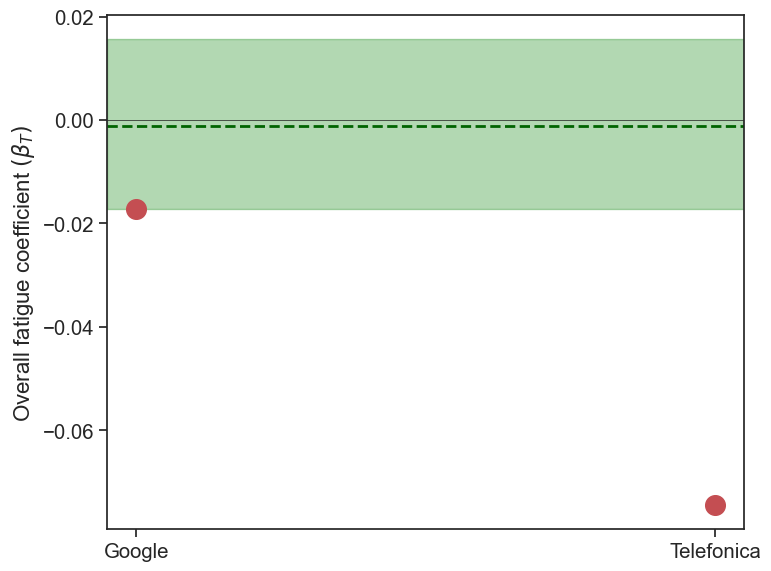

In [61]:
# Chile google mobility data

tFigSize=(8,6)
iFontSize=(tFigSize[0]/tFigSize[1])*(1-0)
sns.set(font_scale=iFontSize*1, style='ticks')
fig, subfig = plt.subplots( figsize=tFigSize)
subfig.scatter(x=DfResChl.index, y=DfResChl.values ,s =200, c='r', zorder=3)
# draw line at median value of OTF coeff for the other countries under model 8
median=np.median(DfResMod.loc['Google','Model 1',['California','Italy','Ontario','Scotland','South Africa'],'Slope','Overall fatigue'][
    ('Residential','Est. Residential')].values)
subfig.axhline(y=median, linestyle='--', c='darkgreen', linewidth=2)
# draw line at 0
subfig.axhline(y=0, c='k', linewidth=0.5)
# draw area between max and min of values reached by OTF in model 8 all regions but Chile
OTFmin=DfResMod.loc['Google','Model 1',['California','Italy','Ontario','Scotland','South Africa'],'Slope','Overall fatigue'][
    ('Residential','Est. Residential')].values.min()
OTFmax=DfResMod.loc['Google','Model 1',['California','Italy','Ontario','Scotland','South Africa'],'Slope','Overall fatigue'][
    ('Residential','Est. Residential')].values.max()
subfig.axhspan(OTFmin,OTFmax,color='green', alpha=0.3)

subfig.set_ylabel('Overall fatigue coefficient '+r'$(\beta_T)$')
fig.tight_layout()

fig.savefig('../../Figures/Adherence/SI/OTF_CHL_GoogleData.png', dpi=120)

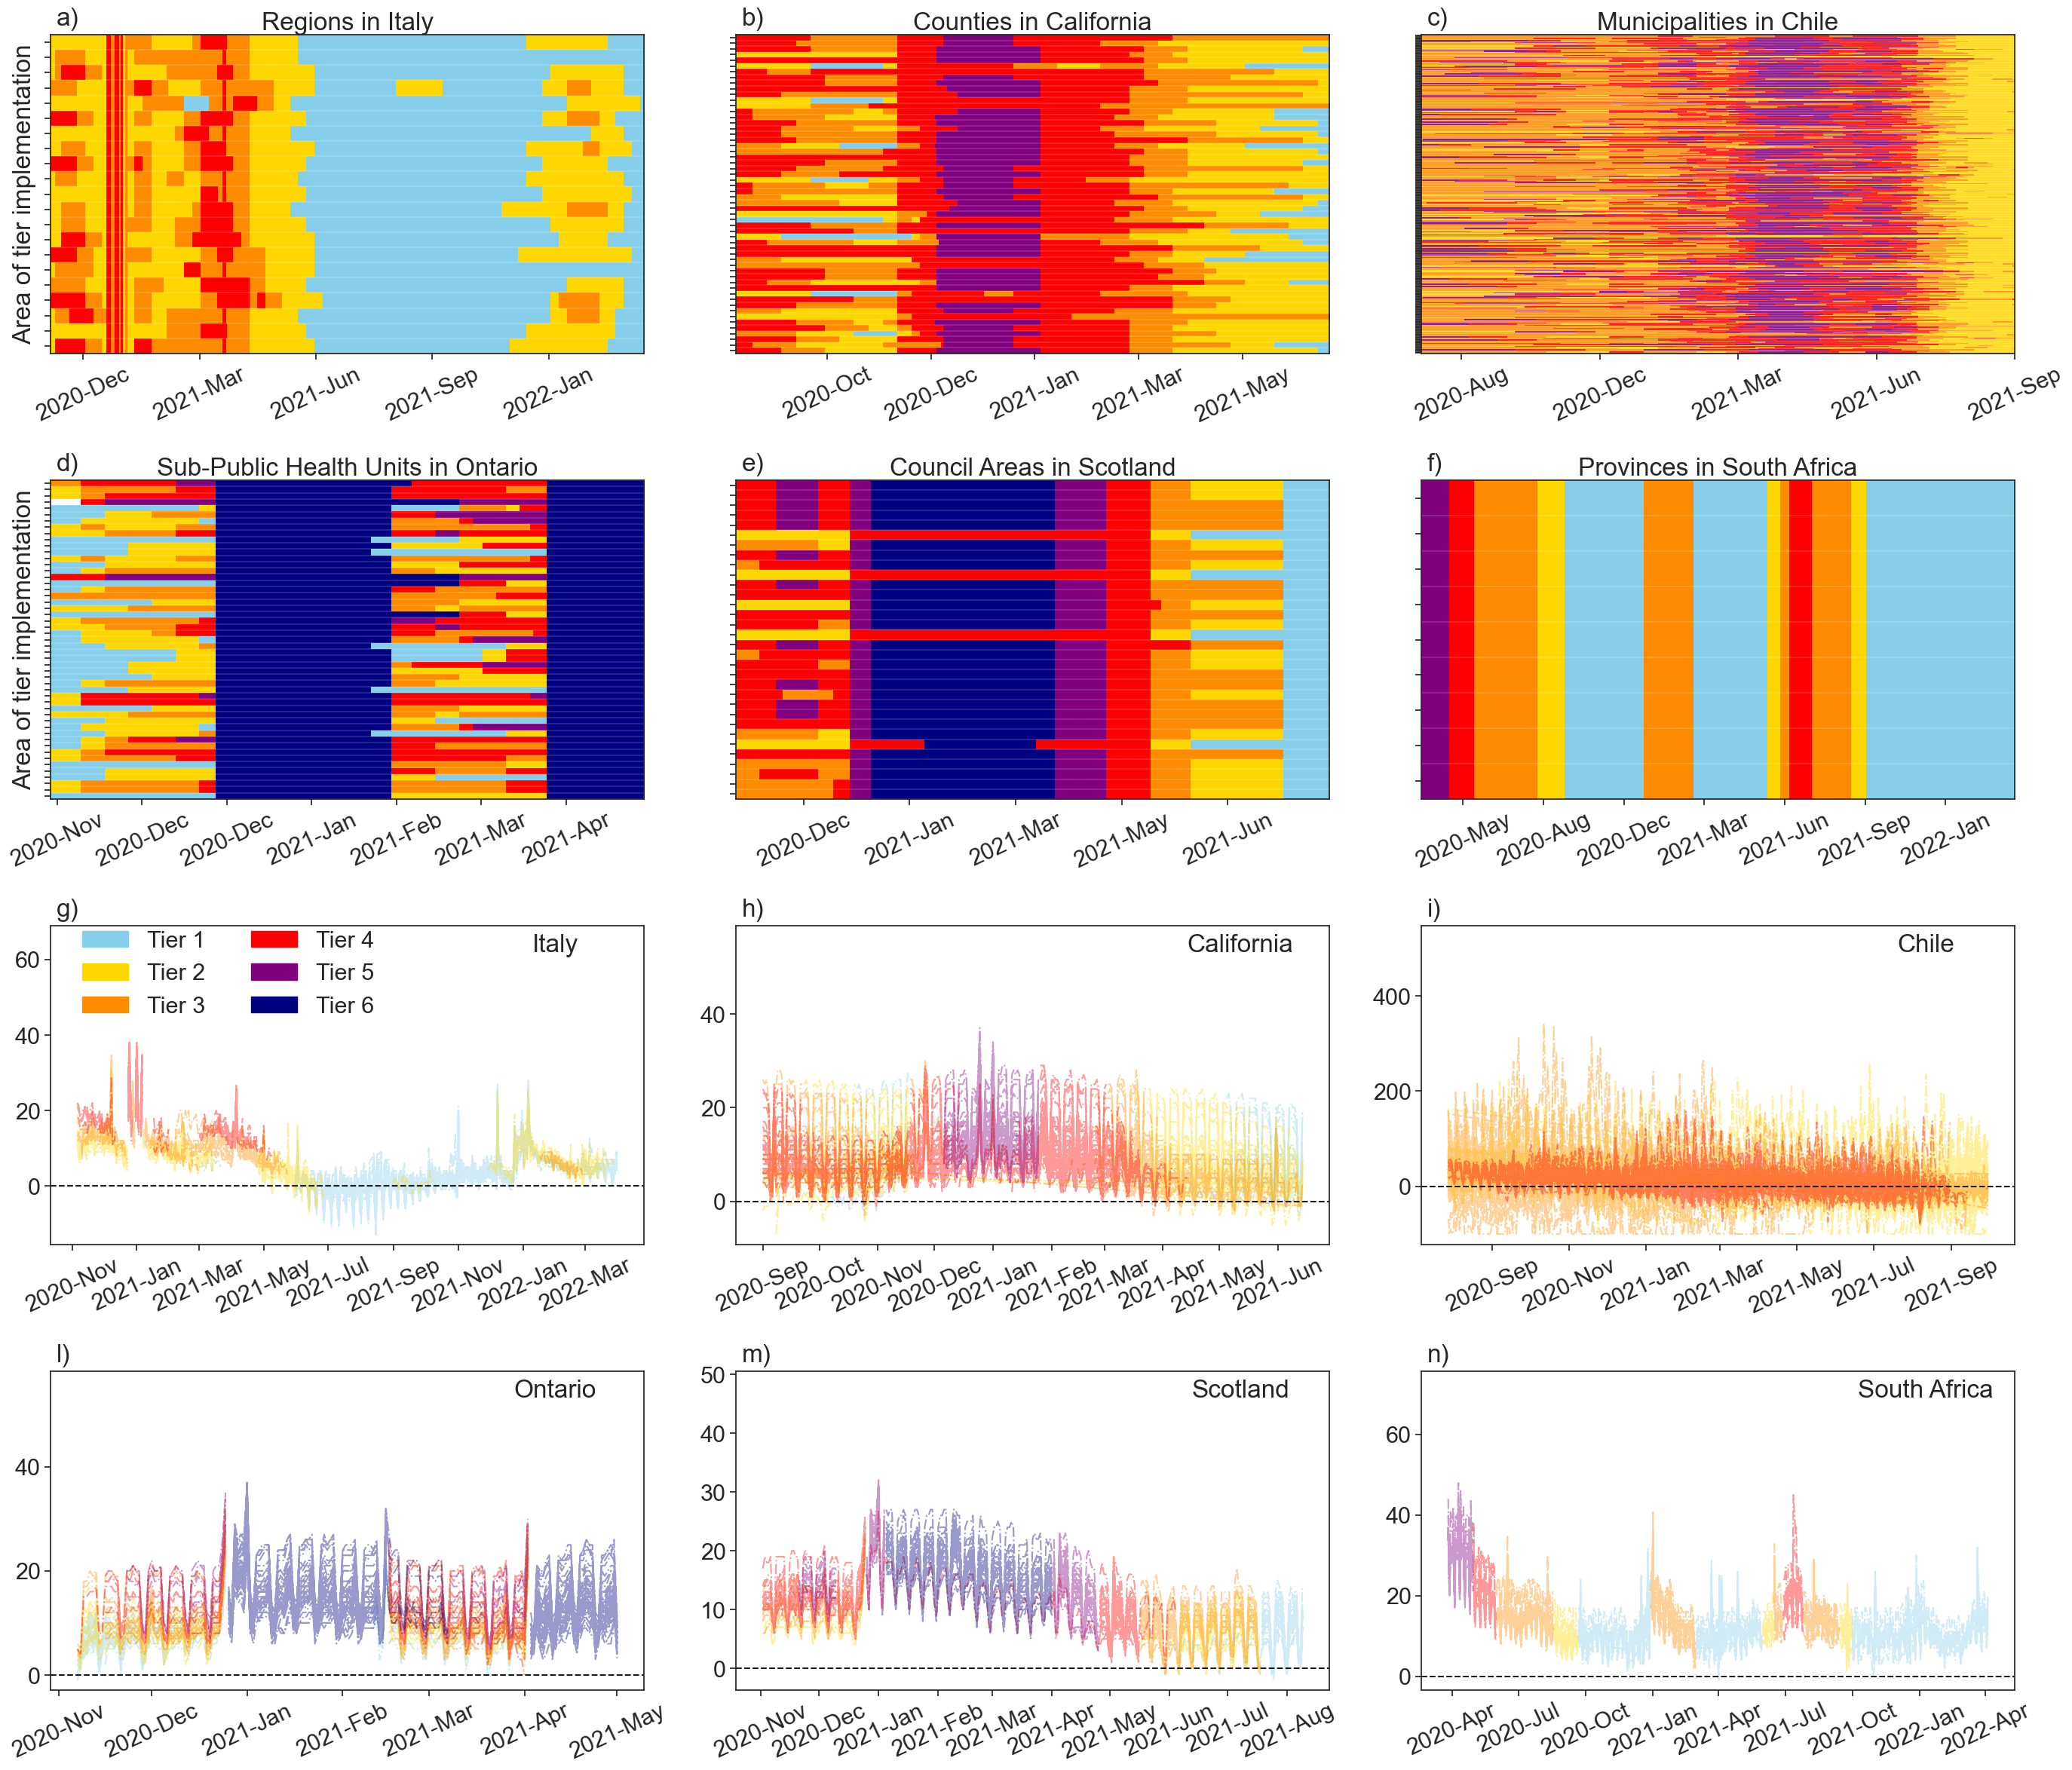

In [15]:
## Figure 1, timeline mobility and tiers

tFigSize=(28,24)
sns.set(font_scale=2, style='ticks')  

lyLabel=['Residential time', 'Presence at workplaces']
cmap = colors.ListedColormap(list(DColLev.values()))
bounds= np.arange(1,8)
norm = colors.BoundaryNorm(bounds,6)
DSpatialRes={'ITA':'Regions','ENG':'Local Authorities','SCO':'Council Areas','CA':'Counties', 'CHL':'Municipalities',
             'Ont':'Sub-Public Health Units', 'ZAF':'Provinces'}
lLabelPanel= ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)', 'h)', 'i)', 'l)', 'm)', 'n)', 'o)']

sMob ='Residential'
fig, ax = plt.subplots(nrows=4, ncols=3,figsize=tFigSize)
ax= ax.ravel()
# counter on panels
iPanel= 0
for sPlot in ['NPIs', 'Mobility']:
    for sCnt in ['ITA','CA', 'CHL', 'Ont', 'SCO', 'ZAF']:
        
        # plot NPIs
        if sPlot=='NPIs':
            data=DDfData['Google'][sCnt].set_index(['Region','Date'])[['Level']].unstack('Date')['Level'].sort_index().values
            x_lims = mdates.date2num([DDfData['Google'][sCnt].min()['Date'], DDfData['Google'][sCnt].max()['Date']])
            # plot
            ax[iPanel].imshow(data, interpolation='none', origin='lower',aspect="auto", cmap=cmap, norm=norm,extent=[x_lims[0],x_lims[1], 0, 
                                len(DDfData['Google'][sCnt].Region.drop_duplicates().values)] )
    
            [ax[iPanel].axhline(y=r, xmax=1, color='w',lw=0.2) for r in np.arange(len(DDfData['Google'][sCnt].Region.drop_duplicates().values))+1]

            # axis labels
            ax[iPanel].set_yticklabels('') 
            ax[iPanel].set_yticks(np.arange(len(DDfData['Google'][sCnt].Region.drop_duplicates().values))+0.5)
             # labels only on the first column
            if iPanel in [0,3]:
                ax[iPanel].set_ylabel('Area of tier implementation')
            else:
                ax[iPanel].set_ylabel('')
            # make space for title
            #ax[iPanel].set_ylim((ax[iPanel].get_ylim()[0], ax[iPanel].get_ylim()[1]*1.1))
            ax[iPanel].set_title(label=DSpatialRes[sCnt]+' in '+ DNames[sCnt],loc='center', transform=ax[iPanel].transAxes)


        
        # plot mobility data
        if sPlot=='Mobility':
            for iLevel in np.arange(1,DiLenLevels[sCnt]+1):
                if iLevel in DDfData['Google'][sCnt].Level.drop_duplicates().values:
                    Dftemp= DDfData['Google'][sCnt][['Date','Level',sMob, 'TotDays']].copy()
                    Dftemp.loc[Dftemp['Level']!= iLevel, sMob]=np.nan
                    x=Dftemp['Date']
                    y=Dftemp[sMob]
                    ax[iPanel].plot(x, y, c=DColLev[iLevel], alpha=0.4, linestyle='-.')
                
                    # fit linear for the trend
                    eq_trend = smf.ols("{} ~ TotDays ".format(sMob), Dftemp )
                    fit_res= eq_trend.fit()
                    slope=fit_res.params['TotDays']
                    intercept= fit_res.params['Intercept']
                    Dftemp['Trend']= intercept + Dftemp['TotDays']*slope
                    x=Dftemp[Dftemp['Level']==iLevel]['Date']
                    y=Dftemp[Dftemp['Level']==iLevel]['Trend']

            ax[iPanel].axhline(0, c='k', linestyle='--')
            # names geographical regions
            ax[iPanel].set_title(DNames[sCnt], x=0.85, y=0.9)
            # labels only on the first column
            if iPanel in [0,3]:
                ax[iPanel].set_ylabel('Change in '+lyLabel[iMob]+ '(%)')
            else:
                ax[iPanel].set_ylabel('')
            # make space for title
            if (iPanel >6) :
                ax[iPanel].set_ylim((ax[iPanel].get_ylim()[0], ax[iPanel].get_ylim()[1]*1.5))

        ax[iPanel].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
        ax[iPanel].tick_params('x',labelrotation=25)
        ax[iPanel].set_xlabel('')

        # label subplot
        ax[iPanel].text(s=lLabelPanel[iPanel], x=0.01, y=1.03, transform=ax[iPanel].transAxes)
        iPanel+=1

# make space for legend/title
ax[6].set_ylim((ax[6].get_ylim()[0], ax[6].get_ylim()[1]*1.7))
hands = [ mpatches.Patch(color=DColLev[l], label="Tier "+str(l)) for l in np.arange(1,7)]
ax[6].legend(handles=hands , ncol=2, bbox_to_anchor=(0.58,1.05), loc=1, frameon=False)

plt.tight_layout()

if sMob == 'Residential':
    fig.savefig('../../Figures/Adherence/Revision2/Manuscript/Figure_1.png', dpi=120)

plt.show()


In [ ]:
## Figure 2, illustration fatigues

fig, ax = plt.subplots(1, figsize=(12,6))
sns.set(font_scale=1.4, style='ticks')  
plt.rcParams['axes.spines.top'] = False

Dftemp= DDfData['Google']['ITA'][['Date','Region','Level',IsMob, 'TotDays']].set_index('Region').loc['Lombardy'].set_index('Date'
                                                                                                    ).loc[idx['2021-01-09':'2021-02-14']].reset_index().copy()


for iLevel in Dftemp.Level.drop_duplicates().values:
    Df = Dftemp.copy()
    Df.loc[Df['Level']!= iLevel, IsMob]=np.nan

    x=Df['Date']
    y=Df[IsMob]
    col=DColLev[iLevel]
    
    ax.plot(x, y, c=col, lw= 2.3, linestyle='-.')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
ax.set_xlabel('Date')
ax.set_ylabel('Change in Residential time (%)')

plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

#fig.savefig('../../Figures/Adherence/Rebuttal/Mob_Case_IllustrationFatigue.pdf', dpi=120)


/Users/albano/Desktop/Ricerca/EPIcx/Code/Adherence/PlotFunctions.py:1567: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  lRegSort).fillna('none')['Marker'])


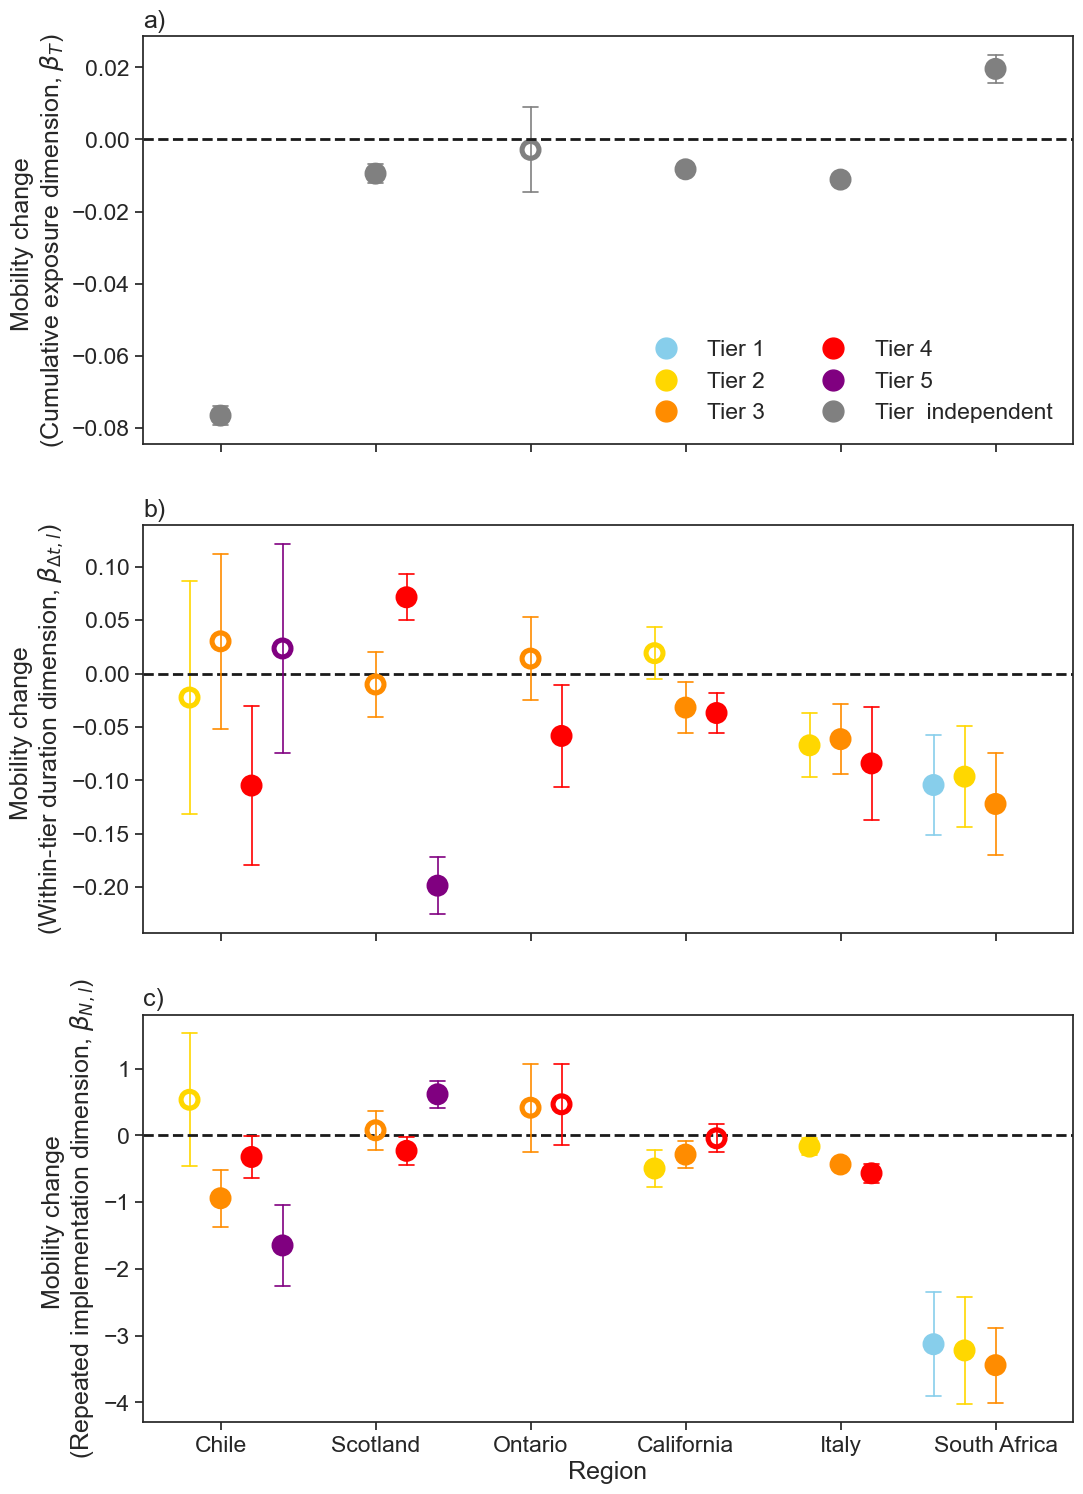

In [13]:
# Figure 3
pf.fFig_3(DfResMod, DColLev, sMainModel, lDimLabels)


/var/folders/dz/3bsppcmx5999bfk4_fnr0xj40000gp/T/ipykernel_1787/1547135148.py:61: PerformanceWarning: indexing past lexsort depth may impact performance.
  DftempBar.loc[(sCnt,lDimLabels[2],iLevel),'At -1%']=iOcc*DfMedDuration.loc[iLevel]['T_Level']
/opt/anaconda3/envs/E_Adherence/lib/python3.11/site-packages/seaborn/categorical.py:645: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  g_vals = grouped_vals.get_group(g)
/opt/anaconda3/envs/E_Adherence/lib/python3.11/site-packages/seaborn/categorical.py:645: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  g_vals = grouped_vals.get_group(g)
/opt/anaconda3/envs/E_Adherence/lib/python3.11/site-packages/seaborn/categorical.py:645: FutureWarning: 

Chile Cumulative exposure Level
0    13.057628
Name: At -1%, dtype: float64
Chile Within-tier duration Level
4    9.53577
Name: At -1%, dtype: float64
Chile Repeated implementation Level
3    30.0
4    69.0
5    37.0
Name: At -1%, dtype: float64
Scotland Cumulative exposure Level
0    105.515511
Name: At -1%, dtype: float64
Scotland Within-tier duration Level
5    5.035923
Name: At -1%, dtype: float64
Scotland Repeated implementation Level
4    84.0
Name: At -1%, dtype: float64
California Cumulative exposure Level
0    120.736499
Name: At -1%, dtype: float64
California Within-tier duration Level
3    31.395873
4    27.074715
Name: At -1%, dtype: float64
California Repeated implementation Level
2    96.0
3    84.0
Name: At -1%, dtype: float64
Italy Cumulative exposure Level
0    89.8103
Name: At -1%, dtype: float64
Italy Within-tier duration Level
2    14.891135
3    16.287040
4    11.888216
Name: At -1%, dtype: float64
Italy Repeated implementation Level
2    175.0
3     30.0
4     22.

/opt/anaconda3/envs/E_Adherence/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/E_Adherence/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/E_Adherence/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/E_Adherence/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

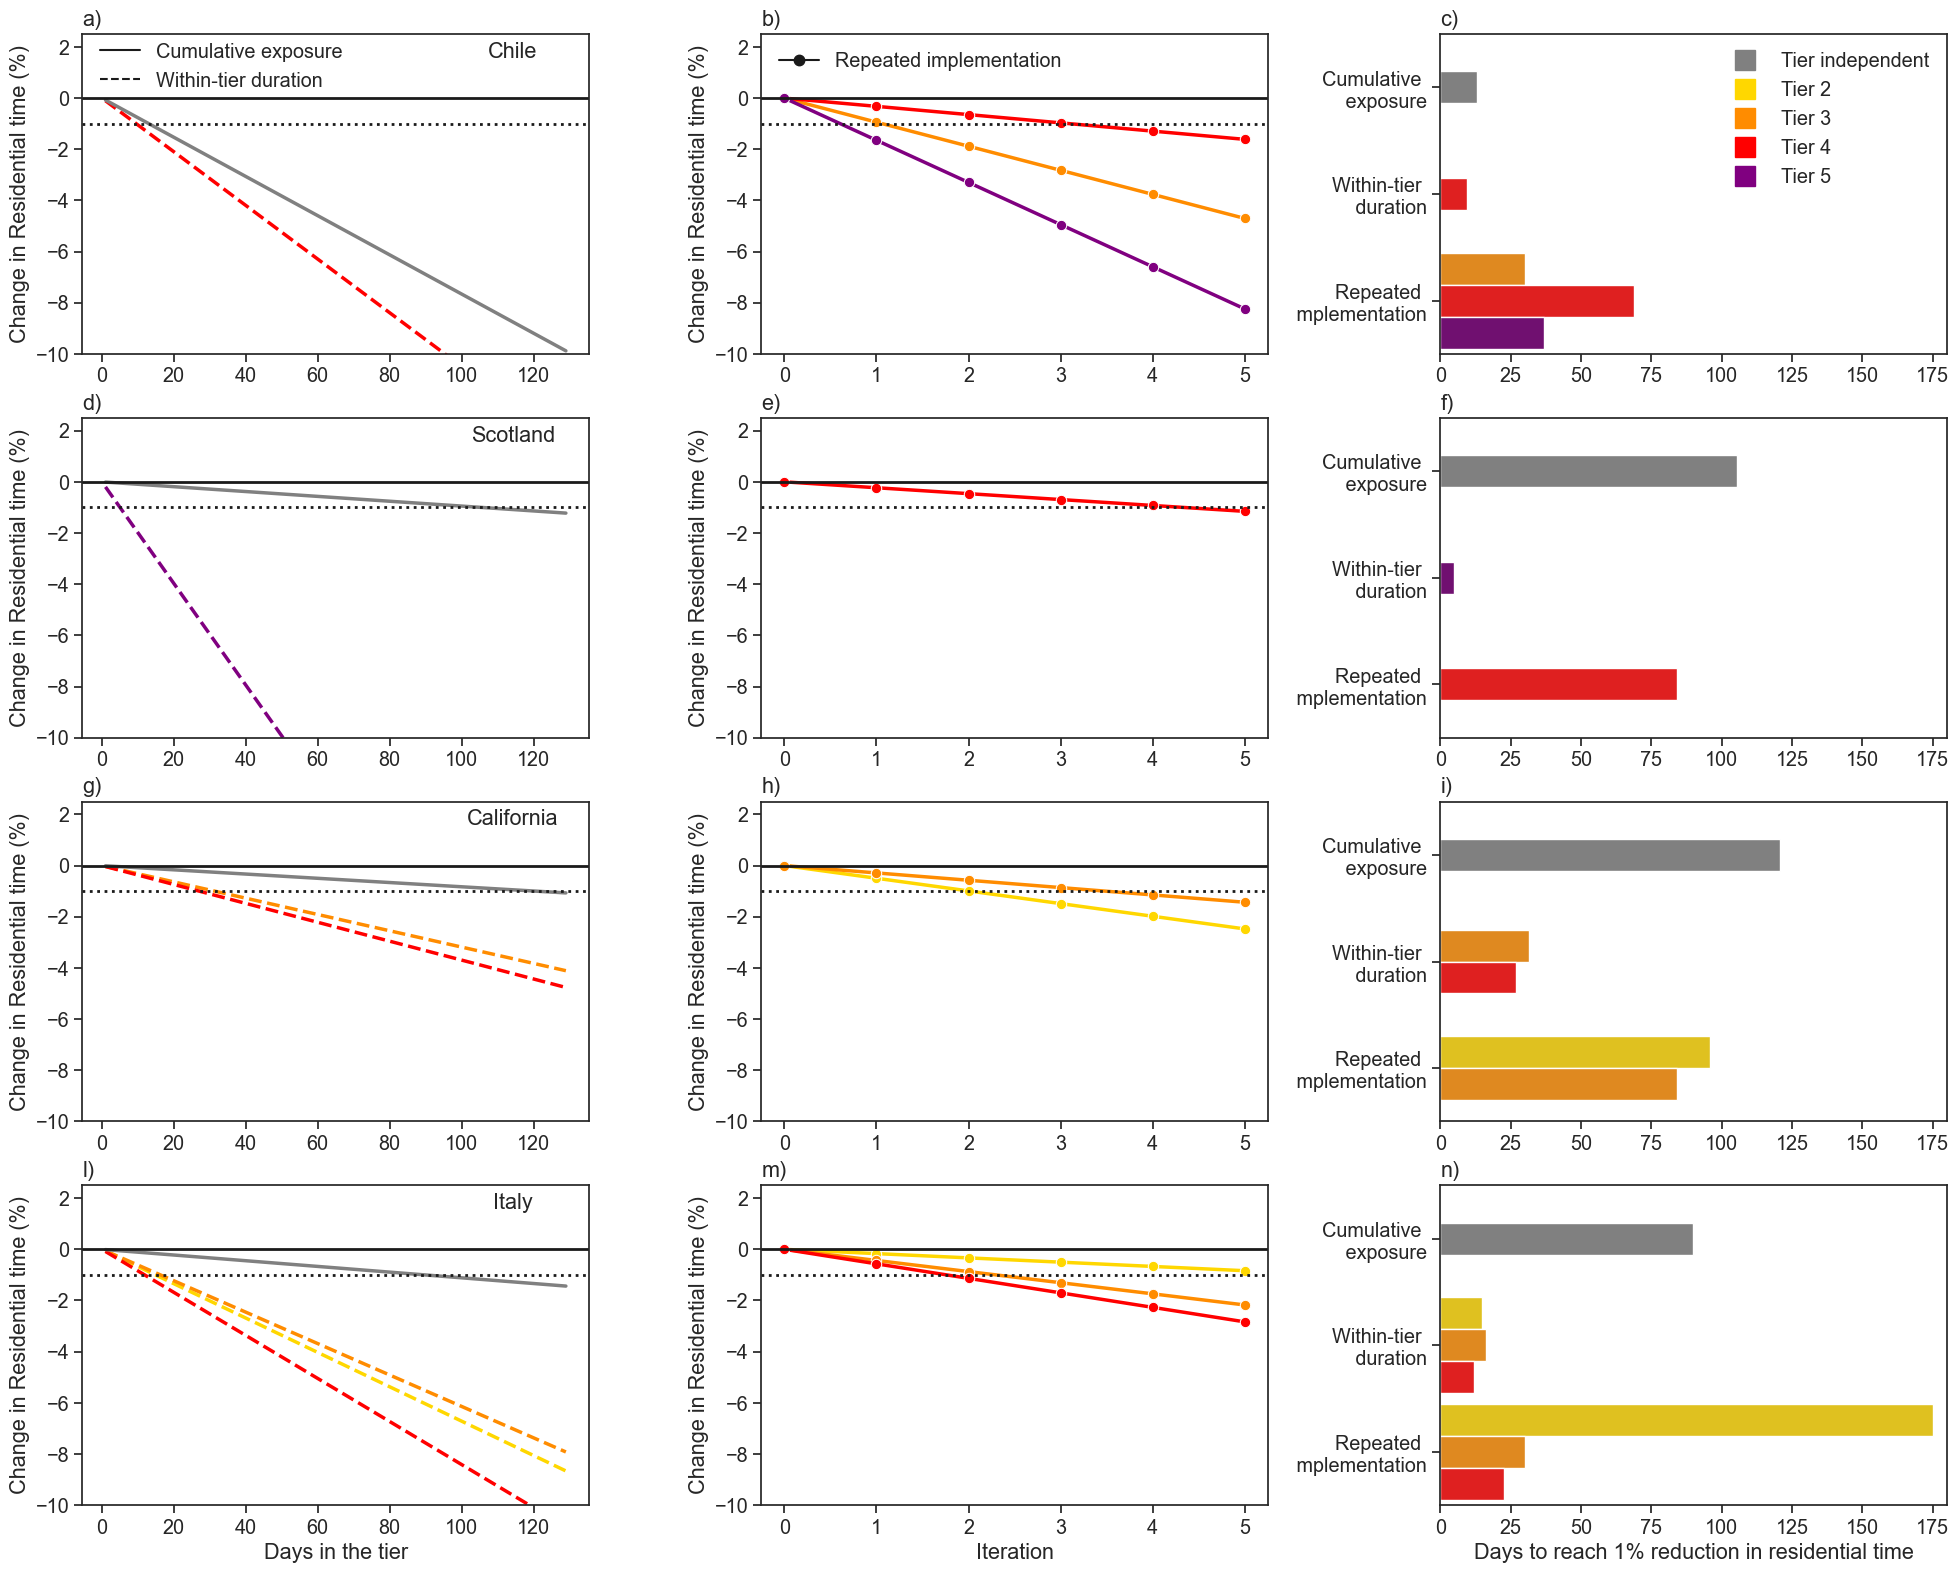

In [43]:
# New figure 4
DxLine={'Workplaces':1, 'Residential':-1}
sns.set(font_scale=1.3 ,style='ticks')
DsMobType={'Residential':'time', 'Workplaces':'presence'}
DNamesLongToShort= dict(zip(list(DNames.values()),list(DNames.keys())))
DColAll={0:'grey', 1: 'skyblue', 2: 'gold', 3: 'darkorange', 4: 'red', 5: 'purple'}
DLabelPanel= {'Chile':['a)', 'b)', 'c)'],'Scotland':[ 'd)', 'e)', 'f)'],'California':[ 'g)', 'h)', 'i)'], 'Italy':['l)', 'm)', 'n)']}
sMob= 'Residential'
fig, ax = plt.subplots(4,3,figsize=(20,16))
i=0
DCollectDataPlot= {'Chile':[], 'Scotland':[], 'California':[], 'Italy':[]}

for iCnt, sCnt in enumerate(['Chile', 'Scotland', 'California', 'Italy']):
           
        aOcc= np.arange(6)#np.arange(DDfData['Google'][DNamesLongToShort[sCnt]].max()['NOccurrence']+1)
        aLev=DfResMod.sort_index().loc['Google',sMainModel,sCnt,'Slope',lDimLabels[2]].index.droplevel(0).values
        aLev=aLev[aLev>0]
        iDays=130
        aDays= np.arange(1,iDays)
        aDaysTier=np.arange(1,50)
        hand=[] 
        labe=[]
        
        idxLevOcc=np.where((abs(DfResMod.loc['Google',sMainModel,sCnt,'Slope',lDimLabels[2],:,:][sMob,'Est. '+sMob])>\
                abs(DfResMod.loc['Google',sMainModel,sCnt,'Slope',lDimLabels[2],:,:][sMob,'CI95% '+sMob])).values==True)[0]
        lLevFigOcc=list((abs(DfResMod.loc['Google',sMainModel,sCnt,'Slope',lDimLabels[2],:,:][sMob,'Est. '+sMob])>\
                abs(DfResMod.loc['Google',sMainModel,sCnt,'Slope',lDimLabels[2],:,:][sMob,'CI95% '+sMob])
                ).iloc[idxLevOcc].droplevel(0).index.values)
       
        idxLevLoc=np.where((abs(DfResMod.loc['Google',sMainModel,sCnt,'Slope',lDimLabels[1],:,:][sMob,'Est. '+sMob])>\
                abs(DfResMod.loc['Google',sMainModel,sCnt,'Slope',lDimLabels[1],:,:][sMob,'CI95% '+sMob])).values==True)[0]
        lLevFigLoc=list((abs(DfResMod.loc['Google',sMainModel,sCnt,'Slope',lDimLabels[2],:,:][sMob,'Est. '+sMob])>\
                abs(DfResMod.loc['Google',sMainModel,sCnt,'Slope',lDimLabels[2],:,:][sMob,'CI95% '+sMob])
                ).iloc[idxLevLoc].droplevel(0).index.values)
        lTierPlot=lLevFigLoc+ lLevFigOcc
        lTierPlot.sort()
      

        ### Hist plot total days passed until the n-th occurrence
        
        if lTierPlot:
            DfMedDuration=DDfData['Google'][DNamesLongToShort[sCnt]][['Region','Level','NOccurrence','T_Level']].copy()
            DfMedDuration=DfMedDuration[(DfMedDuration['T_Level']>=7) & (DfMedDuration['NOccurrence']>=1)]
            DfMedDuration=DfMedDuration.groupby(['Region','Level','NOccurrence']).max().loc[idx[:,lTierPlot],].groupby(['Level']
                                                        ).median()
            
        DftempBar=DfResMod.loc['Google', sMainModel, :,'Slope', lDimLabels].droplevel( level=[0,1,3,5])['Residential'].copy()
        DftempBar=DftempBar[abs(DftempBar['CI95% '+sMob])< abs(DftempBar['Est. '+sMob])].drop(columns=['CI95% '+sMob])
        DftempBar= DftempBar[DftempBar['Est. '+sMob]<0]
        DftempBar['At -1%']=np.abs(1/DftempBar)
        DftempBar=DftempBar.rename(level=2, index={'Global':0})
        # trasform value of occ in days
        Dftemp=DftempBar.loc[sCnt,lDimLabels[2],:].astype({'At -1%':'int'}).reset_index().rename(columns={'At -1%':'NOccurrence'})
        for i in range(Dftemp.shape[0]):
            iLevel=Dftemp.Level[i]
            iOcc= Dftemp.NOccurrence[i]
            
            if sCnt=='Chile' and iLevel==5:
                iOcc=1
           
            DftempBar.loc[(sCnt,lDimLabels[2],iLevel),'At -1%']=iOcc*DfMedDuration.loc[iLevel]['T_Level']
     
        for sMobDime in lDimLabels:
            if (sMobDime==lDimLabels[0]) | (sMobDime==lDimLabels[1]) & (iCnt<2) | (sMobDime==lDimLabels[2]) & (iCnt==1):
                dWidth=0.3
            else:
                if (iCnt==2) & (sMobDime!=lDimLabels[0]):
                    dWidth=0.6
                else:
                    dWidth=0.9
            sns.barplot(x='At -1%', y= 'Parameter', data=DftempBar.loc[idx[sCnt, sMobDime,:,:],].reset_index(),hue='Level', 
                        width=dWidth,palette=DColAll, order=lDimLabels, ax=ax[iCnt,2])

            ax[iCnt, 2].set_yticklabels(['Cumulative \n exposure', 'Within-tier \n duration', 'Repeated \n mplementation'])


            DCollectDataPlot[sCnt].append(DftempBar.loc[idx[sCnt, sMobDime,:,:],'At -1%'])
            print (sCnt,sMobDime, DftempBar.loc[sCnt, sMobDime,:,:]['At -1%'])

        ax[iCnt,2].legend([],[], frameon=False)
        ax[iCnt,2].set_ylabel('')

        ax[iCnt,2].set_title(DLabelPanel[sCnt][2], loc='left')
        ax[iCnt,0].set_title(DLabelPanel[sCnt][0], loc='left')
        ax[iCnt,1].set_title(DLabelPanel[sCnt][1], loc='left')


        if sCnt=='Scotland':
            lLevFigOcc.pop(1)
            lLevFigLoc.pop(0)
        for l in aLev:
        # condition plotting only significant levels
            if l in lLevFigOcc:
                dBetaL=DfResMod.loc['Google',sMainModel,sCnt,'Slope',lDimLabels[2],:,l][sMob,'Est. '+sMob][0]
                yOcc= dBetaL*aOcc
                sns.lineplot(x=aOcc, y=yOcc, c=DColLev[l], label='Level '+str(l),marker='.',
                                         markersize=15, ax=ax[iCnt,1], linewidth=2.5 )       
            if l in lLevFigLoc:
                dBetaLoc=DfResMod.droplevel(5).loc['Google',sMainModel,sCnt,'Slope',lDimLabels[1],
                                              l][sMob,'Est. '+sMob]
                yTot=dBetaLoc*aDays
                sns.lineplot(x=aDays, y=yTot, label=lDimLabels[1], linestyle='--', linewidth=2.5, 
                                 c=DColLev[l], ax=ax[iCnt,0])
        if abs(DfResMod.loc['Google',sMainModel,sCnt,'Slope',lDimLabels[0],'TotDays','Global'][sMob,'CI95% '+sMob])<\
                abs(DfResMod.loc['Google',sMainModel,sCnt,'Slope',lDimLabels[0],'TotDays','Global'][sMob,'Est. '+sMob]):
            
                dBetaO=DfResMod.loc['Google',sMainModel,sCnt,'Slope',lDimLabels[0],'TotDays','Global'][sMob,'Est. '+sMob]
                yTot=dBetaO*aDays
                sns.lineplot(x=aDays, y=yTot, ax=ax[iCnt,0], label=lDimLabels[0], c='grey', linewidth=2.5)

        ax[iCnt,0].set_ylim(ymin=-10, ymax=2.5)
        ax[iCnt,1].set_ylim(ymin=-10, ymax=2.5)
        ax[iCnt,2].set_xlim(xmax=180)

        ax[iCnt,0].legend([],[], frameon=False)
        ax[iCnt,1].axhline(0, linestyle='-', linewidth=2, c='k')
        ax[iCnt,1].axhline(-1, linestyle=':', linewidth=2, c='k')
        ax[iCnt,0].axhline(0, linestyle='-', linewidth=2, c='k')
        ax[iCnt,0].axhline(-1, linestyle=':', linewidth=2, c='k')
        ax[iCnt,1].set_ylabel('Change in Residential time (%)')
        ax[iCnt,0].set_ylabel('Change in Residential time (%)')
        
        ax[iCnt,1].legend([],[], frameon=False)
        ax[iCnt,2].legend([],[], frameon=False)

        for i in range(3):    
            if iCnt!=3:
                ax[iCnt,i].set_xlabel('')
        
        ax[iCnt,0].set_title(sCnt,y=0.9, x=0.85)
ax[3,0].set_xlabel('Days in the tier')
ax[3,1].set_xlabel('Iteration')
ax[3,2].set_xlabel('Days to reach 1% reduction in residential time')

lCols=list(DColAll.values())
hand=[mlines.Line2D([], [], color=col, marker='s', linestyle='', markersize=15) for col in lCols]
lab=['Tier '+lev for lev in ['independent','1','2','3','4','5']]
lab.pop(1)
hand.pop(1)
ax[0,2].legend(ncol=1, handles=hand, labels=lab, frameon=False,  loc=1)

TD = mlines.Line2D([], [], color='k', linestyle='--', label=lDimLabels[1])
RI = mlines.Line2D([], [], color='k', marker='.', markersize=15, label=lDimLabels[2])
CE = mlines.Line2D([], [], color='k', linestyle='-', label=lDimLabels[0])
#if sCnt=='CHL':
ax[0,0].legend(handles=[CE,TD], ncol=1,loc=2, bbox_to_anchor=(0,1.03) ,frameon=False)
ax[0,1].legend(handles=[RI], ncol=1,loc=2, frameon=False)


fig.tight_layout()
fig.subplots_adjust(hspace=0.2)

fig.savefig('../../Figures/Adherence/Revision2/Manuscript/Figure_4.png', dpi=120)
fig.savefig('../../Figures/Adherence/Revision2/Manuscript/Figure_4.pdf')

In [82]:
DCollectDataPlot

{'Chile': [Region  Parameter        Level
  Chile   Overall fatigue  0        13.057628
  Name: At -1%, dtype: float64,
  Region  Parameter     Level
  Chile   Tier fatigue  4        9.53577
  Name: At -1%, dtype: float64,
  Region  Parameter          Level
  Chile   Iteration fatigue  3        30.0
                             4        69.0
                             5        37.0
  Name: At -1%, dtype: float64],
 'Scotland': [Region    Parameter        Level
  Scotland  Overall fatigue  0        105.515511
  Name: At -1%, dtype: float64,
  Region    Parameter     Level
  Scotland  Tier fatigue  5        5.035923
  Name: At -1%, dtype: float64,
  Region    Parameter          Level
  Scotland  Iteration fatigue  4        84.0
  Name: At -1%, dtype: float64],
 'California': [Region      Parameter        Level
  California  Overall fatigue  0        120.736499
  Name: At -1%, dtype: float64,
  Region      Parameter     Level
  California  Tier fatigue  3        31.395873
              